In [46]:
!pip install flwr[simulation] 

In [47]:
!pip install flwr-datasets[vision]

In [48]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from collections import OrderedDict
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, random_split, Subset
from torchvision import transforms
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from typing import List, Dict, Tuple, Any
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_recall_fscore_support
from torchvision import models
import warnings
import random
import torchvision.transforms as transforms
from datasets.utils.logging import disable_progress_bar
from torch.utils.data import DataLoader
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_recall_fscore_support
import os
import random
import warnings
warnings.filterwarnings('ignore')

import flwr 
from flwr.common import Context, Parameters
from flwr.server import ServerApp, ServerAppComponents, ServerConfig
from flwr.client import ClientApp, NumPyClient, Client
from flwr.server.strategy import FedProx
from flwr.common.parameter import parameters_to_ndarrays, ndarrays_to_parameters
from flwr.simulation import run_simulation

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu") 
print(f"Training on {DEVICE}")
print(f"Flower {flwr.__version__} / PyTorch {torch.__version__}")
disable_progress_bar()

Training on cuda
Flower 1.25.0 / PyTorch 2.8.0+cu126


In [49]:
# from datasets.utils.logging import disable_progress_bar
# DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu") 
# print(f"Training on {DEVICE}")
# print(f"Flower {flwr.__version__}")
# disable_progress_bar()

In [50]:
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

In [51]:
print("="*60)
print("SETTING UP NON-IID DATA PARTITIONING WITH DIRICHLET DISTRIBUTION")
print("="*60)

# Configuration
NUM_CLIENTS = 3
BATCH_SIZE = 10
EPOCHS_PER_ROUND=3
server_round = 50
NUM_ROUNDS=50
epochs=3# REDUCED from 5 to prevent overfitting
DATASET_PATH = "/kaggle/input/cervical-cancer-largest-dataset-sipakmed"
ALPHA = 0.3  # REDUCED from 1.0 for MORE balanced (less non-IID) distribution
MU = 0.01  # INCREASED from 0.1 for stronger regularization

SETTING UP NON-IID DATA PARTITIONING WITH DIRICHLET DISTRIBUTION


In [52]:
# NUM_CLIENTS = 3
# BATCH_SIZE = 10
# EPOCHS_PER_ROUND=3
# server_round = 25
# NUM_ROUNDS=50
# epochs=3# REDUCED from 5 to prevent overfitting
# DATASET_PATH = "/kaggle/input/cervical-cancer-largest-dataset-sipakmed"
# ALPHA = 0.3  # REDUCED from 1.0 for MORE balanced (less non-IID) distribution
# MU = 0.00001  # INCREASED from 0.1 for stronger regularization

In [53]:
train_transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

val_transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

# Custom dataset path - point directly to where CROPPED folders are
from torch.utils.data import Dataset
from PIL import Image

class CroppedImageDataset(Dataset):
    def __init__(self, root_path, transform=None):
        self.transform = transform
        self.samples = []
        self.classes = ['Dyskeratotic', 'Koilocytotic', 'Metaplastic', 
                        'Parabasal', 'Superficial-Intermediate']
        self.class_to_idx = {cls: idx for idx, cls in enumerate(self.classes)}
        
        # Load images from CROPPED folders
        class_folders = ['im_Dyskeratotic', 'im_Koilocytotic', 'im_Metaplastic', 
                        'im_Parabasal', 'im_Superficial-Intermediate']
        
        for class_folder in class_folders:
            # Path: root/im_ClassName/im_ClassName/CROPPED/
            cropped_folder = os.path.join(root_path, class_folder, class_folder, 'CROPPED')
            
            # Get class name without 'im_' prefix
            class_name = class_folder.replace('im_', '')
            class_idx = self.class_to_idx[class_name]
            
            # Check if CROPPED folder exists
            if os.path.exists(cropped_folder):
                # Get all .bmp files
                for img_name in os.listdir(cropped_folder):
                    if img_name.endswith('.bmp'):
                        img_path = os.path.join(cropped_folder, img_name)
                        self.samples.append((img_path, class_idx))
        
        print(f"Loaded {len(self.samples)} images from CROPPED folders")
    
    def __len__(self):
        return len(self.samples)
    
    def __getitem__(self, idx):
        img_path, label = self.samples[idx]
        image = Image.open(img_path).convert('RGB')
        
        if self.transform:
            image = self.transform(image)
        
        return image, label

# 1. Load SIPaKMeD using custom dataset (NO transform initially)
dataset = CroppedImageDataset(root_path=DATASET_PATH, transform=None)
print("Classes:", dataset.classes)
print(f"Total dataset size: {len(dataset)}")
print(f"Number of classes: {len(dataset.classes)}")

# 2. Create GLOBAL train/validation split (80/20) BEFORE partitioning
print("\n" + "="*60)
print("CREATING GLOBAL TRAIN/VALIDATION SPLIT")
print("="*60)
total_size = len(dataset)
train_size = int(0.8 * total_size)  # 80% for training
val_size = total_size - train_size   # 20% for global validation
train_dataset_raw, val_dataset_raw = random_split(
    dataset, [train_size, val_size]
)
print(f"Training samples (to be partitioned): {len(train_dataset_raw)}")
print(f"Global validation samples (held-out): {len(val_dataset_raw)}")

# Wrapper class to apply transforms to a Subset
class TransformSubset(Dataset):
    def __init__(self, subset, transform=None):
        self.subset = subset
        self.transform = transform
        # Get reference to the base dataset
        self.base_dataset = subset.dataset
    
    def __len__(self):
        return len(self.subset)
    
    def __getitem__(self, idx):
        # Get the actual index in the base dataset
        actual_idx = self.subset.indices[idx]
        # Get image path and label from base dataset
        img_path, label = self.base_dataset.samples[actual_idx]
        image = Image.open(img_path).convert('RGB')
        
        if self.transform:
            image = self.transform(image)
        
        return image, label

# Apply train_transform to training set
train_dataset = TransformSubset(train_dataset_raw, transform=train_transform)

# Apply val_transform to validation set
global_val_dataset = TransformSubset(val_dataset_raw, transform=val_transform)

# Create global validation DataLoader (used by ALL clients)
global_valloader = DataLoader(global_val_dataset, batch_size=BATCH_SIZE, shuffle=False)
print(f"Global validation DataLoader created with {len(global_valloader)} batches")

# 3. Partition ONLY the training data among clients (IID)
print("\n" + "="*60)
print("PARTITIONING TRAINING DATA AMONG CLIENTS (IID)")
print("="*60)

def partition_dataset(dataset, num_clients=NUM_CLIENTS):
    """
    Partition dataset into IID chunks for clients
    """
    data_per_client = len(dataset) // num_clients
    indices = np.random.permutation(len(dataset))
    partitions = []
    
    for i in range(num_clients):
        start = i * data_per_client
        end = (i+1) * data_per_client if i != num_clients-1 else len(dataset)
        client_indices = indices[start:end]
        partitions.append(Subset(dataset, client_indices))
    
    return partitions

# Partition the training data (not the full dataset!)
partitions = partition_dataset(train_dataset, NUM_CLIENTS)

# 4. Each client gets its own DataLoader for TRAINING ONLY
def load_client_train_data(partition_id: int):
    """
    Returns only training DataLoader for a client
    (No local validation split anymore)
    """
    partition = partitions[partition_id]
    trainloader = DataLoader(partition, batch_size=BATCH_SIZE, shuffle=True)
    return trainloader

# 5. Verification and Visualization
print("\n" + "="*60)
print("VERIFICATION AND VISUALIZATION")
print("="*60)
# Example: Get training data for client 0
trainloader = load_client_train_data(0)
print(f"Client 0 training samples: {len(trainloader.dataset)}")
# Show a batch from training
train_batch = next(iter(trainloader))
train_images, train_labels = train_batch
print(f"Training batch shape: {train_images.shape}")
# Show a batch from global validation
val_batch = next(iter(global_valloader))
val_images, val_labels = val_batch
print(f"Global validation batch shape: {val_images.shape}")

Loaded 4049 images from CROPPED folders
Classes: ['Dyskeratotic', 'Koilocytotic', 'Metaplastic', 'Parabasal', 'Superficial-Intermediate']
Total dataset size: 4049
Number of classes: 5

CREATING GLOBAL TRAIN/VALIDATION SPLIT
Training samples (to be partitioned): 3239
Global validation samples (held-out): 810
Global validation DataLoader created with 81 batches

PARTITIONING TRAINING DATA AMONG CLIENTS (IID)

VERIFICATION AND VISUALIZATION
Client 0 training samples: 1079
Training batch shape: torch.Size([10, 3, 128, 128])
Global validation batch shape: torch.Size([10, 3, 128, 128])


In [54]:
# ============================================================================
# DIRICHLET PARTITIONING
# ============================================================================
def dirichlet_partition_indices(dataset_indices, labels, num_clients, alpha=1.0):
    """
    Partition indices using Dirichlet distribution
    """
    num_classes = len(np.unique(labels))
    
    # Group indices by class
    class_indices = {c: [] for c in range(num_classes)}
    for idx, label in zip(dataset_indices, labels):
        class_indices[label].append(idx)
    
    partitions = [[] for _ in range(num_clients)]
    
    # Distribute each class's indices
    for class_id in range(num_classes):
        indices = class_indices[class_id]
        if not indices:
            continue
            
        np.random.shuffle(indices)
        
        # Generate Dirichlet proportions
        proportions = np.random.dirichlet([alpha] * num_clients)
        
        # Convert to counts
        counts = (proportions * len(indices)).astype(int)
        
        # Adjust counts to match total
        total_assigned = np.sum(counts)
        if total_assigned < len(indices):
            remaining = len(indices) - total_assigned
            counts[:remaining] += 1
        
        # Assign indices to clients
        current_idx = 0
        for client_id in range(num_clients):
            count = counts[client_id]
            if count > 0:
                partitions[client_id].extend(indices[current_idx:current_idx + count])
                current_idx += count
    
    return partitions

# Get training indices and labels
train_indices = train_dataset_raw.indices
# FIX: Get labels from the base dataset using the samples
train_labels = [dataset.samples[i][1] for i in train_indices]

# Apply Dirichlet partitioning
print(f"\nApplying Dirichlet partitioning with alpha={ALPHA}...")
partition_indices = dirichlet_partition_indices(
    train_indices, train_labels, NUM_CLIENTS, ALPHA
)

# Verify partitioning
print("\nPartition statistics:")
for i, partition in enumerate(partition_indices):
    partition_labels = [dataset.samples[idx][1] for idx in partition]
    class_counts = np.bincount(partition_labels, minlength=len(dataset.classes))
    print(f"Client {i}: {len(partition)} samples | Class distribution: {class_counts}")


Applying Dirichlet partitioning with alpha=0.3...

Partition statistics:
Client 0: 963 samples | Class distribution: [482   7 260  37 177]
Client 1: 1435 samples | Class distribution: [ 43 514   4 549 325]
Client 2: 841 samples | Class distribution: [152 145 363  28 153]


In [55]:
# ============================================================================
# ANALYZE PARTITION STATISTICS
# ============================================================================

print("\n" + "="*60)
print("PARTITION STATISTICS")
print("="*60)

for client_id in range(NUM_CLIENTS):
    indices = partition_indices[client_id]
    if indices:
        labels = [dataset.samples[i][1] for i in indices]
        label_counts = np.bincount(labels, minlength=len(dataset.classes))
        total = len(indices)
        
        print(f"Client {client_id}: {total} samples")
        print(f"  Class distribution: {label_counts.tolist()}")
        
        # Show top 2 classes
        top_classes = np.argsort(label_counts)[-2:][::-1]
        for class_id in top_classes:
            if label_counts[class_id] > 0:
                percentage = (label_counts[class_id] / total) * 100
                print(f"    {dataset.classes[class_id]}: {percentage:.1f}%")
    else:
        print(f"Client {client_id}: No data")

print(f"\nTotal training samples assigned: {sum(len(p) for p in partition_indices)}")


PARTITION STATISTICS
Client 0: 963 samples
  Class distribution: [482, 7, 260, 37, 177]
    Dyskeratotic: 50.1%
    Metaplastic: 27.0%
Client 1: 1435 samples
  Class distribution: [43, 514, 4, 549, 325]
    Parabasal: 38.3%
    Koilocytotic: 35.8%
Client 2: 841 samples
  Class distribution: [152, 145, 363, 28, 153]
    Metaplastic: 43.2%
    Superficial-Intermediate: 18.2%

Total training samples assigned: 3239


In [56]:
# CREATE DATA LOADERS
# ============================================================================

print("\n" + "="*60)
print("CREATING DATA LOADERS")
print("="*60)

global_val_dataset = Subset(dataset, val_dataset_raw.indices)
global_val_dataset = [(val_transform(img), label) for img, label in global_val_dataset]

val_images = torch.stack([item[0] for item in global_val_dataset])
val_labels = torch.tensor([item[1] for item in global_val_dataset])
global_val_tensor_dataset = torch.utils.data.TensorDataset(val_images, val_labels)
global_valloader = DataLoader(global_val_tensor_dataset, batch_size=BATCH_SIZE, shuffle=False)

print(f"Global validation loader: {len(global_valloader)} batches, {len(global_val_tensor_dataset)} samples")

def load_client_train_data(partition_id: int):
    """Create DataLoader for a specific client"""
    indices = partition_indices[partition_id]
    
    if not indices:
        empty_data = torch.zeros(0, 3, 28, 28)
        empty_labels = torch.zeros(0, dtype=torch.long)
        empty_dataset = torch.utils.data.TensorDataset(empty_data, empty_labels)
        return DataLoader(empty_dataset, batch_size=BATCH_SIZE, shuffle=True)
    
    client_images = []
    client_labels = []
    
    for idx in indices:
        img, label = dataset[idx]
        img_tensor = train_transform(img)
        client_images.append(img_tensor)
        client_labels.append(label)
    
    client_images = torch.stack(client_images)
    client_labels = torch.tensor(client_labels)
    client_dataset = torch.utils.data.TensorDataset(client_images, client_labels)
    
    # CRITICAL FIX: Ensure batch size is at least 2 for BatchNorm
    # Also use drop_last=True to avoid single-sample batches
    effective_batch_size = min(BATCH_SIZE, len(client_dataset))
    effective_batch_size = max(2, effective_batch_size)  # Minimum 2 for BatchNorm
    
    trainloader = DataLoader(
        client_dataset,
        batch_size=effective_batch_size,
        shuffle=True,
        drop_last=True if len(client_dataset) > effective_batch_size else False,  # Drop last incomplete batch
        pin_memory=True
    )
    
    return trainloader


CREATING DATA LOADERS
Global validation loader: 81 batches, 810 samples



Testing client 0 data loader...
Client 0: 963 samples, 96 batches
Sample batch shape: torch.Size([10, 3, 128, 128])
Sample labels: [0, 2, 0, 0, 2]


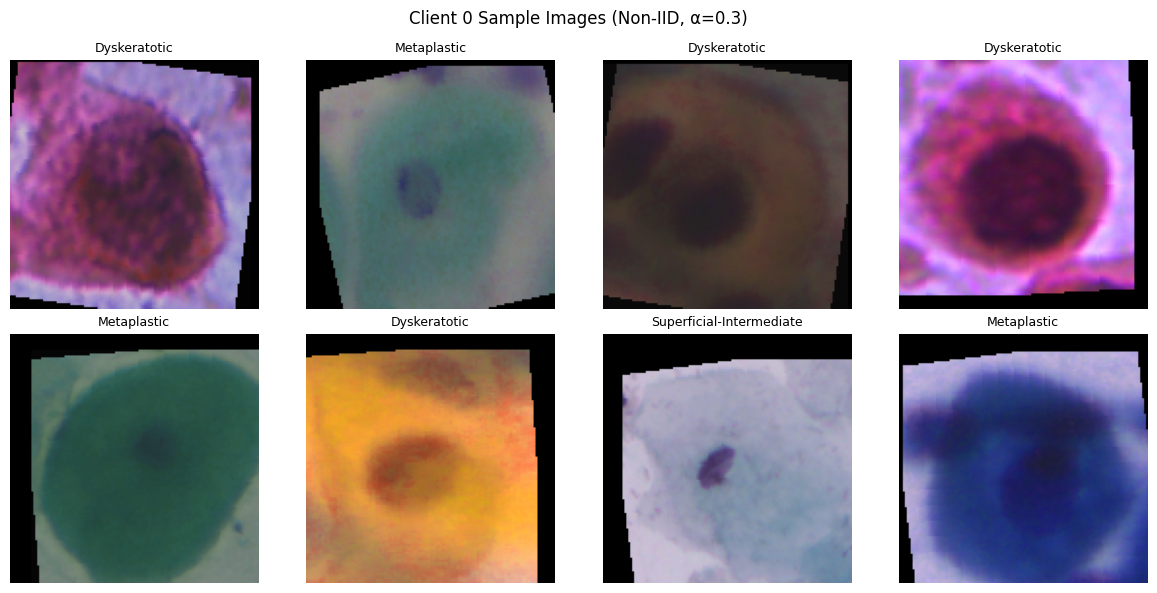

In [57]:
# Test loading for client 0
print("\nTesting client 0 data loader...")
client0_loader = load_client_train_data(0)
print(f"Client 0: {len(client0_loader.dataset)} samples, {len(client0_loader)} batches")

# Show a sample batch
if len(client0_loader) > 0:
    images, labels = next(iter(client0_loader))
    print(f"Sample batch shape: {images.shape}")
    print(f"Sample labels: {labels[:5].tolist()}")
    
    # Quick visualization
    fig, axes = plt.subplots(2, 4, figsize=(12, 6))
    for i, ax in enumerate(axes.flat):
        if i < len(images):
            img = images[i].permute(1, 2, 0).numpy()
            img = (img * 0.5) + 0.5  # Denormalize
            img = np.clip(img, 0, 1)
            
            ax.imshow(img)
            ax.set_title(dataset.classes[labels[i].item()], fontsize=9)
            ax.axis('off')
    
    plt.suptitle(f"Client 0 Sample Images (Non-IID, α={ALPHA})", fontsize=12)
    plt.tight_layout()
    plt.show()


VISUALIZING NON-IID DISTRIBUTION


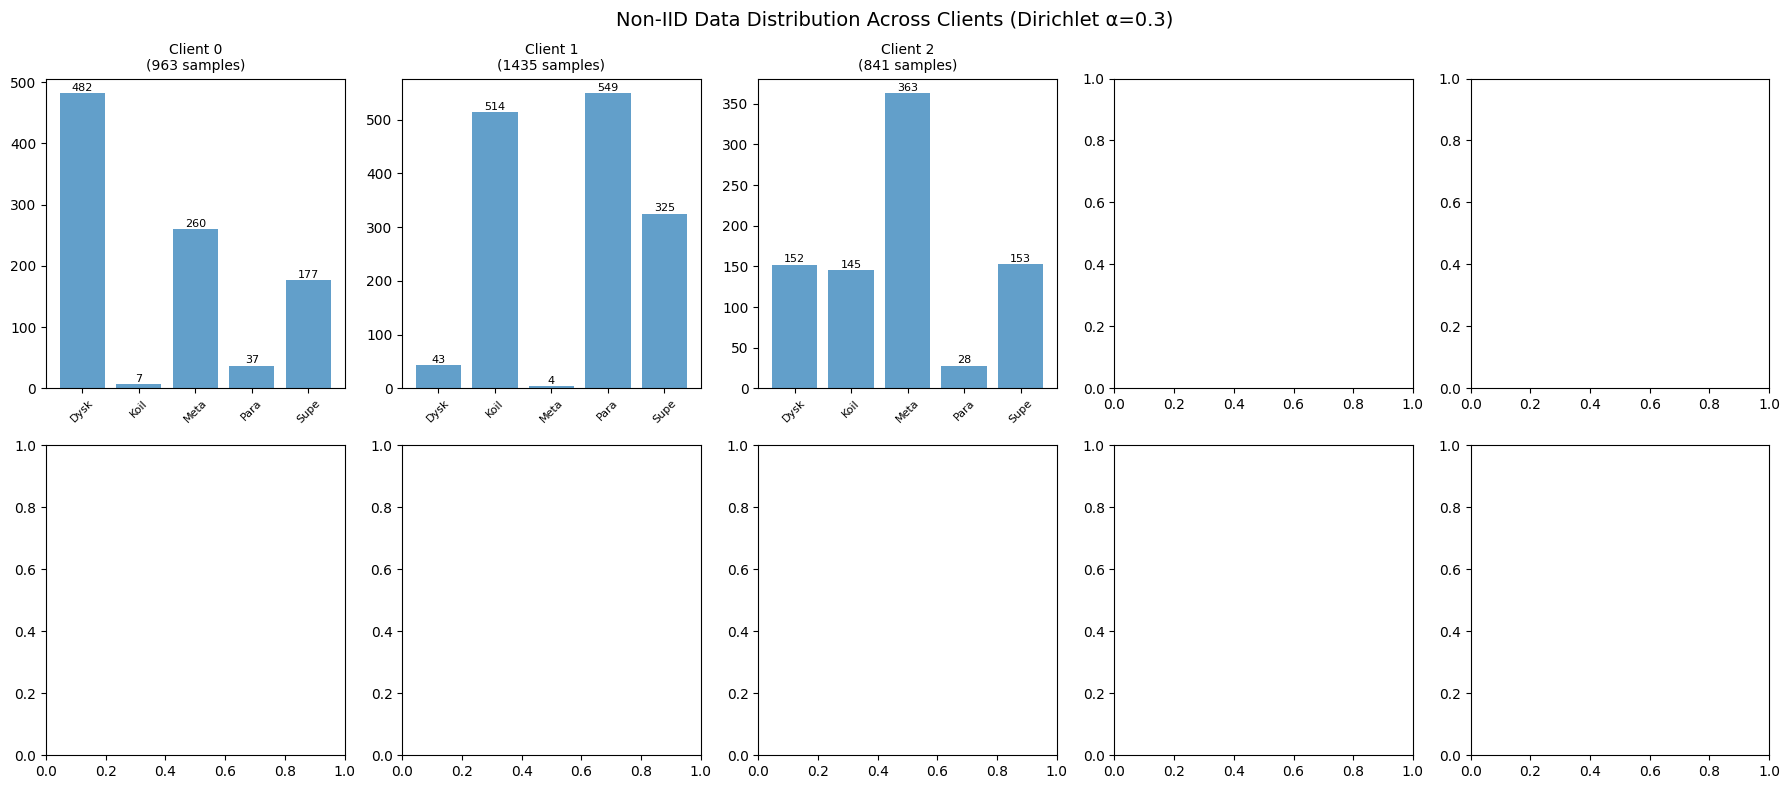


Overall Statistics:
Samples per client: [963, 1435, 841]
Mean: 1079.7, Std: 256.1
Min: 841, Max: 1435

DATA PREPARATION COMPLETE


In [58]:
# ============================================================================
# VISUALIZE NON-IID DISTRIBUTION
# ============================================================================

print("\n" + "="*60)
print("VISUALIZING NON-IID DISTRIBUTION")
print("="*60)

# Create visualization
fig, axes = plt.subplots(2, 5, figsize=(18, 8))
axes = axes.flatten()

for client_id in range(min(NUM_CLIENTS,10)):
    ax = axes[client_id]
    indices = partition_indices[client_id]
    
    if indices:
        labels = [dataset.samples[i][1] for i in indices]
        label_counts = np.bincount(labels, minlength=len(dataset.classes))
        
        # Create bar chart
        bars = ax.bar(range(len(label_counts)), label_counts, alpha=0.7)
        ax.set_title(f'Client {client_id}\n({len(indices)} samples)', fontsize=10)
        ax.set_xticks(range(len(label_counts)))
        ax.set_xticklabels([c[:4] for c in dataset.classes], rotation=45, fontsize=8)
        
        # Add count labels on top bars
        for i, count in enumerate(label_counts):
            if count > 0:
                ax.text(i, count + 0.5, str(count), ha='center', va='bottom', fontsize=8)
    
    else:
        ax.text(0.5, 0.5, f'Client {client_id}\nNo data', 
               ha='center', va='center', transform=ax.transAxes)
        ax.set_xticks([])
        ax.set_yticks([])

plt.suptitle(f'Non-IID Data Distribution Across Clients (Dirichlet α={ALPHA})', fontsize=14)
plt.tight_layout()
plt.show()

# Calculate and show overall statistics
print("\nOverall Statistics:")
samples_per_client = [len(indices) for indices in partition_indices]
print(f"Samples per client: {samples_per_client}")
print(f"Mean: {np.mean(samples_per_client):.1f}, Std: {np.std(samples_per_client):.1f}")
print(f"Min: {np.min(samples_per_client)}, Max: {np.max(samples_per_client)}")

print("\n" + "="*60)
print("DATA PREPARATION COMPLETE")
print("="*60)


In [59]:
# Calculate and show overall statistics
print("\nOverall Statistics:")
samples_per_client = [len(indices) for indices in partition_indices]
print(f"Samples per client: {samples_per_client}")
print(f"Mean: {np.mean(samples_per_client):.1f}, Std: {np.std(samples_per_client):.1f}")
print(f"Min: {np.min(samples_per_client)}, Max: {np.max(samples_per_client)}")

print("\n" + "="*60)
print("DATA PREPARATION COMPLETE")
print("="*60)


Overall Statistics:
Samples per client: [963, 1435, 841]
Mean: 1079.7, Std: 256.1
Min: 841, Max: 1435

DATA PREPARATION COMPLETE


In [60]:
# ============================================================================
# DATA LEAKAGE DETECTION CODE
# ============================================================================

print("\n" + "="*60)
print("DATA LEAKAGE DETECTION")
print("="*60)

# 1. Get all indices
train_indices_set = set()
for client_id in range(NUM_CLIENTS):
    train_indices_set.update(partition_indices[client_id])

val_indices_set = set(val_dataset_raw.indices)

# 2. Check overlap between train and validation
overlap = train_indices_set.intersection(val_indices_set)
print(f"1. Train-Validation Overlap: {len(overlap)} samples")
if overlap:
    print(f"   ERROR: Data leakage detected!")
    print(f"   Overlapping indices (first 10): {list(overlap)[:10]}")
    
    # Show which samples are overlapping
    for idx in list(overlap)[:5]:
        img_path = dataset.samples[idx][0] if hasattr(dataset, 'samples') else f"index_{idx}"
        print(f"   - Index {idx}: {img_path}")
else:
    print("   GOOD: No overlap between train and validation sets")

# 3. Check for duplicate samples within train partitions
print(f"\n2. Duplicate Samples in Training Partitions:")
train_all_indices = []
for client_id in range(NUM_CLIENTS):
    train_all_indices.extend(partition_indices[client_id])

# Find duplicates
from collections import Counter
index_counter = Counter(train_all_indices)
duplicates = [idx for idx, count in index_counter.items() if count > 1]

if duplicates:
    print(f"   ERROR: Found {len(duplicates)} duplicate indices in training data!")
    print(f"   Duplicate indices (first 10): {duplicates[:10]}")
    
    # Show which clients share which samples
    for idx in duplicates[:5]:
        sharing_clients = []
        for client_id in range(NUM_CLIENTS):
            if idx in partition_indices[client_id]:
                sharing_clients.append(client_id)
        print(f"   - Index {idx} appears in clients: {sharing_clients}")
else:
    print("   GOOD: No duplicate samples across training partitions")

# 4. Check client-to-client overlap
print(f"\n3. Client-to-Client Overlap Analysis:")
client_overlaps = []
for i in range(NUM_CLIENTS):
    for j in range(i+1, NUM_CLIENTS):
        overlap_ij = set(partition_indices[i]).intersection(set(partition_indices[j]))
        if overlap_ij:
            client_overlaps.append((i, j, len(overlap_ij)))

if client_overlaps:
    print(f"   ERROR: Found {len(client_overlaps)} client pairs sharing data!")
    for i, j, count in client_overlaps:
        print(f"   - Clients {i} and {j} share {count} samples")
        if count <= 10:
            print(f"     Shared indices: {list(set(partition_indices[i]).intersection(set(partition_indices[j])))}")
else:
    print("   GOOD: No overlap between client partitions")

# 5. Check if all data is used
total_train_samples = len(train_all_indices)
total_val_samples = len(val_indices_set)
expected_total = len(dataset)
actual_total = total_train_samples + total_val_samples

print(f"\n4. Dataset Coverage Check:")
print(f"   Training samples: {total_train_samples}")
print(f"   Validation samples: {total_val_samples}")
print(f"   Total used: {actual_total}")
print(f"   Original dataset size: {expected_total}")

if actual_total != expected_total:
    missing = expected_total - actual_total
    print(f"   WARNING: {missing} samples missing!")
    
    # Find missing indices
    all_used_indices = train_indices_set.union(val_indices_set)
    all_possible_indices = set(range(expected_total))
    missing_indices = all_possible_indices - all_used_indices
    print(f"   Missing indices (first 10): {list(missing_indices)[:10]}")
else:
    print("   GOOD: All dataset samples are accounted for")

# 6. Visualize data distribution
print(f"\n5. Data Distribution Visualization:")

# Create a matrix to visualize client-class distribution
num_classes = len(dataset.classes)
distribution_matrix = np.zeros((NUM_CLIENTS, num_classes))

for client_id in range(NUM_CLIENTS):
    for idx in partition_indices[client_id]:
        # FIX: Changed from dataset.samples[i] to dataset.samples[idx][1]
        label = dataset.samples[idx][1]
        distribution_matrix[client_id, label] += 1

print(f"\nClient-Class Distribution Matrix:")
print(" " * 10 + " ".join([f"C{c:3d}" for c in range(num_classes)]))
for client_id in range(NUM_CLIENTS):
    row_str = f"Client {client_id}: "
    for class_id in range(num_classes):
        count = int(distribution_matrix[client_id, class_id])
        row_str += f"{count:4d} "
    print(row_str)

# 7. Check for augmentation leakage
print(f"\n6. Augmentation Consistency Check:")
print("   Train transform includes: RandomHorizontalFlip, RandomRotation")
print("   Validation transform: None (only resize, normalize)")
print("   GOOD: No augmentation in validation (prevents data leakage)")

# 8. Check image file paths for potential issues
print(f"\n7. Image Path Analysis (first 5 samples from each client):")
for client_id in range(NUM_CLIENTS):
    if partition_indices[client_id]:
        print(f"\n   Client {client_id}:")
        for idx in partition_indices[client_id][:5]:
            if hasattr(dataset, 'samples') and idx < len(dataset.samples):
                img_path, label = dataset.samples[idx]
                filename = img_path.split('/')[-1]
                print(f"     - {filename} (Class: {dataset.classes[label]})")

# 9. Statistical analysis
print(f"\n8. Statistical Summary:")
print(f"   Average samples per client: {total_train_samples / NUM_CLIENTS:.1f}")
print(f"   Std dev of client sizes: {np.std([len(p) for p in partition_indices]):.1f}")
print(f"   Min client size: {min([len(p) for p in partition_indices])}")
print(f"   Max client size: {max([len(p) for p in partition_indices])}")

# 10. Class imbalance check
print(f"\n9. Class Imbalance Check:")
print("   Overall class distribution in training:")
for class_id in range(num_classes):
    class_count = 0
    for client_id in range(NUM_CLIENTS):
        class_count += distribution_matrix[client_id, class_id]
    percentage = (class_count / total_train_samples) * 100
    print(f"     {dataset.classes[class_id]}: {int(class_count)} samples ({percentage:.1f}%)")

print("\n   Overall class distribution in validation:")
# FIX: Changed from dataset.targets to dataset.samples
val_class_counts = np.bincount([dataset.samples[i][1] for i in val_indices_set], minlength=num_classes)
for class_id in range(num_classes):
    count = val_class_counts[class_id]
    percentage = (count / len(val_indices_set)) * 100
    print(f"     {dataset.classes[class_id]}: {count} samples ({percentage:.1f}%)")

# 11. Advanced check: Check for similar filenames across splits
print(f"\n10. Filename Pattern Check:")
train_filenames = set()
val_filenames = set()

for idx in train_indices_set:
    if hasattr(dataset, 'samples') and idx < len(dataset.samples):
        img_path, _ = dataset.samples[idx]
        filename = img_path.split('/')[-1]
        train_filenames.add(filename)

for idx in val_indices_set:
    if hasattr(dataset, 'samples') and idx < len(dataset.samples):
        img_path, _ = dataset.samples[idx]
        filename = img_path.split('/')[-1]
        val_filenames.add(filename)

filename_overlap = train_filenames.intersection(val_filenames)
if filename_overlap:
    print(f"   WARNING: {len(filename_overlap)} filenames appear in both train and val!")
    print(f"   Example overlapping filenames (first 5): {list(filename_overlap)[:5]}")
else:
    print(f"   GOOD: No filename overlap between train and validation")

print("\n" + "="*60)
print("DATA LEAKAGE CHECK COMPLETE")
print("="*60)

# Summary
issues = []
if len(overlap) > 0:
    issues.append(f"Train-validation overlap: {len(overlap)} samples")
if len(duplicates) > 0:
    issues.append(f"Training duplicates: {len(duplicates)} samples")
if len(client_overlaps) > 0:
    issues.append(f"Client overlaps: {len(client_overlaps)} pairs")
if actual_total != expected_total:
    issues.append(f"Missing samples: {expected_total - actual_total}")

if issues:
    print(f"\n❌ ISSUES FOUND ({len(issues)}):")
    for issue in issues:
        print(f"   - {issue}")
else:
    print(f"\n✅ ALL CHECKS PASSED! No data leakage detected.")

# Save the analysis to a file for reference
import json
analysis_report = {
    "train_val_overlap": len(overlap),
    "training_duplicates": len(duplicates),
    "client_overlaps": len(client_overlaps),
    "missing_samples": expected_total - actual_total,
    "total_train_samples": total_train_samples,
    "total_val_samples": total_val_samples,
    "client_sizes": [len(p) for p in partition_indices],
    "class_distribution": distribution_matrix.tolist(),
    "validation_class_distribution": val_class_counts.tolist()
}

with open('data_leakage_report.json', 'w') as f:
    json.dump(analysis_report, f, indent=2)

print(f"\n📄 Analysis report saved to 'data_leakage_report.json'")


DATA LEAKAGE DETECTION
1. Train-Validation Overlap: 0 samples
   GOOD: No overlap between train and validation sets

2. Duplicate Samples in Training Partitions:
   GOOD: No duplicate samples across training partitions

3. Client-to-Client Overlap Analysis:
   GOOD: No overlap between client partitions

4. Dataset Coverage Check:
   Training samples: 3239
   Validation samples: 810
   Total used: 4049
   Original dataset size: 4049
   GOOD: All dataset samples are accounted for

5. Data Distribution Visualization:

Client-Class Distribution Matrix:
          C  0 C  1 C  2 C  3 C  4
Client 0:  482    7  260   37  177 
Client 1:   43  514    4  549  325 
Client 2:  152  145  363   28  153 

6. Augmentation Consistency Check:
   Train transform includes: RandomHorizontalFlip, RandomRotation
   Validation transform: None (only resize, normalize)
   GOOD: No augmentation in validation (prevents data leakage)

7. Image Path Analysis (first 5 samples from each client):

   Client 0:
     - 

In [61]:
# class ChannelAttention(nn.Module):
#     """Squeeze-and-Excitation attention for channel-wise feature recalibration"""
#     def __init__(self, channels, reduction=16):
#         super().__init__()
#         self.avg_pool = nn.AdaptiveAvgPool2d(1)
#         self.max_pool = nn.AdaptiveMaxPool2d(1)
        
#         self.fc = nn.Sequential(
#             nn.Linear(channels, channels // reduction, bias=False),
#             nn.ReLU(inplace=True),
#             nn.Linear(channels // reduction, channels, bias=False)
#         )
#         self.sigmoid = nn.Sigmoid()
    
#     def forward(self, x):
#         b, c, _, _ = x.size()
        
#         # Both average and max pooling
#         avg_out = self.fc(self.avg_pool(x).view(b, c))
#         max_out = self.fc(self.max_pool(x).view(b, c))
        
#         out = avg_out + max_out
#         return x * self.sigmoid(out).view(b, c, 1, 1)

# class SpatialAttention(nn.Module):
#     """Spatial attention for spatial feature recalibration"""
#     def __init__(self, kernel_size=7):
#         super().__init__()
#         self.conv = nn.Conv2d(2, 1, kernel_size, padding=kernel_size//2, bias=False)
#         self.sigmoid = nn.Sigmoid()
    
#     def forward(self, x):
#         avg_out = torch.mean(x, dim=1, keepdim=True)
#         max_out, _ = torch.max(x, dim=1, keepdim=True)
#         x_cat = torch.cat([avg_out, max_out], dim=1)
#         attention = self.sigmoid(self.conv(x_cat))
#         return x * attention

# class CBAM(nn.Module):
#     """Convolutional Block Attention Module"""
#     def __init__(self, channels, reduction=16):
#         super().__init__()
#         self.channel_attention = ChannelAttention(channels, reduction)
#         self.spatial_attention = SpatialAttention()
    
#     def forward(self, x):
#         x = self.channel_attention(x)
#         x = self.spatial_attention(x)
#         return x

In [62]:
# class HybridDenseViT(nn.Module):
#     def __init__(self, num_classes=5, dropout=0.5):
#         super(HybridDenseViT, self).__init__()
        
#         # ====================================================================
#         # PATH 1: EfficientNet-B0 Branch (Simplified)
#         # ====================================================================
#         efficientnet = models.efficientnet_b0(
#             weights=models.EfficientNet_B0_Weights.IMAGENET1K_V1
#         )
        
#         # Extract feature stages (simpler)
#         self.eff_features = efficientnet.features
        
#         # ====================================================================
#         # PATH 2: ResNet18 Branch (Simplified)
#         # ====================================================================
#         resnet = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
        
#         # Remove final layers
#         self.res_features = nn.Sequential(
#             resnet.conv1,
#             resnet.bn1,
#             resnet.relu,
#             resnet.maxpool,
#             resnet.layer1,
#             resnet.layer2,
#             resnet.layer3,
#             resnet.layer4
#         )
        
#         # ====================================================================
#         # FIXED: Proper feature dimension calculation
#         # ====================================================================
#         # Get output dimensions for both branches
#         with torch.no_grad():
#             # Create dummy input to get feature dimensions
#             dummy_input = torch.randn(1, 3, 64, 64)
            
#             # Get EfficientNet feature dimension
#             eff_out = self.eff_features(dummy_input)
#             eff_channels = eff_out.shape[1]
            
#             # Get ResNet feature dimension  
#             res_out = self.res_features(dummy_input)
#             res_channels = res_out.shape[1]
        
#         # Total channels after concatenation
#         total_channels = eff_channels + res_channels
        
#         # ====================================================================
#         # ATTENTION MODULES (with correct dimensions)
#         # ====================================================================
#         self.cbam = CBAM(total_channels, reduction=16)
        
#         # ====================================================================
#         # FUSION & CLASSIFIER (with correct dimensions)
#         # ====================================================================
#         # Fusion convolution
#         self.fusion = nn.Sequential(
#             nn.Conv2d(total_channels, 512, 1),
#             nn.BatchNorm2d(512),
#             nn.ReLU(inplace=True)
#         )
        
#         # Global pooling
#         self.global_pool = nn.AdaptiveAvgPool2d((1, 1))
        
#         # FIXED CLASSIFIER: Use 512 as input (from fusion output)
#         self.classifier = nn.Sequential(
#             nn.Dropout(dropout),
#             nn.Linear(512, 256),
#             nn.LayerNorm(256),
#             nn.ReLU(),
#             nn.Dropout(dropout * 0.7),
#             nn.Linear(256, 128),
#             nn.LayerNorm(128),
#             nn.ReLU(),
#             nn.Dropout(dropout * 0.5),
#             nn.Linear(128, num_classes)
#         )
        
#         # Temperature scaling
#         self.temperature = nn.Parameter(torch.ones(1) * 1.0)
        
#     def forward(self, x):
#         # ====================================================================
#         # DUAL PATH FEATURE EXTRACTION
#         # ====================================================================
        
#         # EfficientNet path
#         eff_out = self.eff_features(x)
        
#         # ResNet path
#         res_out = self.res_features(x)
        
#         # ====================================================================
#         # FIX SPATIAL MISMATCHES
#         # ====================================================================
#         # Ensure both have same spatial dimensions
#         if eff_out.shape[2:] != res_out.shape[2:]:
#             target_size = min(eff_out.shape[2], res_out.shape[2])
#             eff_out = F.interpolate(eff_out, size=(target_size, target_size), 
#                                    mode='bilinear', align_corners=False)
#             res_out = F.interpolate(res_out, size=(target_size, target_size), 
#                                    mode='bilinear', align_corners=False)
        
#         # ====================================================================
#         # FEATURE FUSION WITH ATTENTION
#         # ====================================================================
#         # Concatenate features
#         fused = torch.cat([eff_out, res_out], dim=1)
        
#         # Apply attention
#         fused = self.cbam(fused)
        
#         # Fusion convolution
#         fused = self.fusion(fused)
        
#         # ====================================================================
#         # CLASSIFICATION
#         # ====================================================================
#         # Global pooling
#         pooled = self.global_pool(fused)
#         pooled = pooled.flatten(1)
        
#         # Classification
#         logits = self.classifier(pooled)
        
#         # Temperature scaling
#         logits = logits / self.temperature
        
#         return logits

In [63]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models

class ChannelAttention(nn.Module):
    """Squeeze-and-Excitation attention for channel-wise feature recalibration"""
    def __init__(self, channels, reduction=16):
        super().__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.max_pool = nn.AdaptiveMaxPool2d(1)

        self.fc = nn.Sequential(
            nn.Linear(channels, channels // reduction, bias=False),
            nn.ReLU(inplace=True),
            nn.Linear(channels // reduction, channels, bias=False)
        )
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        b, c, _, _ = x.size()

        # Both average and max pooling
        avg_out = self.fc(self.avg_pool(x).view(b, c))
        max_out = self.fc(self.max_pool(x).view(b, c))

        out = avg_out + max_out
        return x * self.sigmoid(out).view(b, c, 1, 1)

class SpatialAttention(nn.Module):
    """Spatial attention for spatial feature recalibration"""
    def __init__(self, kernel_size=7):
        super().__init__()
        self.conv = nn.Conv2d(2, 1, kernel_size, padding=kernel_size//2, bias=False)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        avg_out = torch.mean(x, dim=1, keepdim=True)
        max_out, _ = torch.max(x, dim=1, keepdim=True)
        x_cat = torch.cat([avg_out, max_out], dim=1)
        attention = self.sigmoid(self.conv(x_cat))
        return x * attention

class CBAM(nn.Module):
    """Convolutional Block Attention Module"""
    def __init__(self, channels, reduction=16):
        super().__init__()
        self.channel_attention = ChannelAttention(channels, reduction)
        self.spatial_attention = SpatialAttention()

    def forward(self, x):
        x = self.channel_attention(x)
        x = self.spatial_attention(x)
        return x

class HybridDenseViT(nn.Module):
    def __init__(self, num_classes=5, dropout=0.5):
        super(HybridDenseViT, self).__init__()

        # ====================================================================
        # PATH 1: EfficientNet-B0 Branch
        # ====================================================================
        efficientnet = models.efficientnet_b0(
            weights=models.EfficientNet_B0_Weights.IMAGENET1K_V1
        )

        # Extract feature stages
        self.eff_features = efficientnet.features

        # ====================================================================
        # PATH 2: MobileNetV2 Branch (FIXED)
        # ====================================================================
        mobilenet = models.mobilenet_v2(
            weights=models.MobileNet_V2_Weights.IMAGENET1K_V1
        )

        # MobileNetV2 has 'features' attribute (not conv1, bn1, etc.)
        self.mob_features = mobilenet.features

        # ====================================================================
        # FIXED: Proper feature dimension calculation
        # ====================================================================
        # Get output dimensions for both branches
        with torch.no_grad():
            # Create dummy input to get feature dimensions (224x224 for proper testing)
            dummy_input = torch.randn(1, 3, 224, 224)

            # Get EfficientNet feature dimension
            eff_out = self.eff_features(dummy_input)
            eff_channels = eff_out.shape[1]

            # Get MobileNet feature dimension
            mob_out = self.mob_features(dummy_input)
            mob_channels = mob_out.shape[1]

            print(f"EfficientNet output channels: {eff_channels}")
            print(f"MobileNet output channels: {mob_channels}")
            print(f"EfficientNet spatial size: {eff_out.shape[2:]}")
            print(f"MobileNet spatial size: {mob_out.shape[2:]}")

        # Total channels after concatenation
        total_channels = eff_channels + mob_channels
        print(f"Total concatenated channels: {total_channels}")

        # ====================================================================
        # ATTENTION MODULES (with correct dimensions)
        # ====================================================================
        self.cbam = CBAM(total_channels, reduction=16)

        # ====================================================================
        # FUSION & CLASSIFIER (with correct dimensions)
        # ====================================================================
        # Fusion convolution
        self.fusion = nn.Sequential(
            nn.Conv2d(total_channels, 512, 1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True)
        )

        # Global pooling
        self.global_pool = nn.AdaptiveAvgPool2d((1, 1))

        # Classifier
        self.classifier = nn.Sequential(
            nn.Dropout(dropout),
            nn.Linear(512, 256),
            nn.LayerNorm(256),
            nn.ReLU(),
            nn.Dropout(dropout * 0.7),
            nn.Linear(256, 128),
            nn.LayerNorm(128),
            nn.ReLU(),
            nn.Dropout(dropout * 0.5),
            nn.Linear(128, num_classes)
        )

        # Temperature scaling
        self.temperature = nn.Parameter(torch.ones(1) * 1.0)

    def forward(self, x):
        # ====================================================================
        # DUAL PATH FEATURE EXTRACTION
        # ====================================================================

        # EfficientNet path
        eff_out = self.eff_features(x)

        # MobileNet path
        mob_out = self.mob_features(x)

        # ====================================================================
        # FIX SPATIAL MISMATCHES (if any)
        # ====================================================================
        # Ensure both have same spatial dimensions
        if eff_out.shape[2:] != mob_out.shape[2:]:
            target_size = min(eff_out.shape[2], mob_out.shape[2])
            eff_out = F.interpolate(eff_out, size=(target_size, target_size),
                                   mode='bilinear', align_corners=False)
            mob_out = F.interpolate(mob_out, size=(target_size, target_size),
                                   mode='bilinear', align_corners=False)

        # ====================================================================
        # FEATURE FUSION WITH ATTENTION
        # ====================================================================
        # Concatenate features
        fused = torch.cat([eff_out, mob_out], dim=1)

        # Apply attention
        fused = self.cbam(fused)

        # Fusion convolution
        fused = self.fusion(fused)

        # ====================================================================
        # CLASSIFICATION
        # ====================================================================
        # Global pooling
        pooled = self.global_pool(fused)
        pooled = pooled.flatten(1)

        # Classification
        logits = self.classifier(pooled)

        # Temperature scaling
        logits = logits / self.temperature

        return logits

# Test the model
# if __name__ == "__main__":
#     print("Initializing CCanNet model...")
#     model = CCanNet(num_classes=5, dropout=0.5)

#     # Test forward pass
#     print("\nTesting forward pass...")
#     dummy_input = torch.randn(2, 3, 224, 224)
#     output = model(dummy_input)
#     print(f"Output shape: {output.shape}")

#     # Count parameters
#     total_params = sum(p.numel() for p in model.parameters())
#     trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
#     print(f"\nTotal parameters: {total_params:,}")
#     print(f"Trainable parameters: {trainable_params:,}")

In [64]:
def get_parameters(net) -> list[np.ndarray]:
    """Get ALL model parameters as numpy arrays (consistent with set_parameters)."""
    return [val.cpu().numpy() for _, val in net.state_dict().items()]

def set_parameters(net, parameters: list[np.ndarray]):
    """Set model parameters from numpy arrays."""
    params_dict = zip(net.state_dict().keys(), parameters, strict=True)
    state_dict = OrderedDict({k: torch.tensor(v) for k, v in params_dict})
    net.load_state_dict(state_dict, strict=True)
    return net

def get_initial_parameters():
    """Get initial model parameters."""
    model = HybridDenseViT(num_classes=5, dropout=0.5)
    model.to(DEVICE)
    params = get_parameters(model)
    return ndarrays_to_parameters(params)

def test(net, testloader):
    """Evaluate the network on the entire test set."""
    criterion = torch.nn.CrossEntropyLoss()
    correct, total, loss = 0, 0, 0.0
    net.eval()
    with torch.no_grad():
        for images, labels in testloader:
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            outputs = net(images)
            loss += criterion(outputs, labels).item() * labels.size(0)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    loss = loss / total if total > 0 else 0.0
    accuracy = correct / total if total > 0 else 0.0
    return loss, accuracy

In [65]:
def weighted_average_with_client_tracking(metrics):
    """Aggregate validation metrics with client tracking"""
    accuracies = [num_examples * m["val_accuracy"] for num_examples, m in metrics]
    examples = [num_examples for num_examples, _ in metrics]
    
    aggregated = {
        "val_accuracy": sum(accuracies) / sum(examples) if sum(examples) > 0 else 0,
        "total_examples": sum(examples)
    }
    
    for num_examples, m in metrics:
        client_id = m.get("client_id", -1)
        aggregated[f"client_{client_id}_val_accuracy"] = m.get("val_accuracy", 0)
        aggregated[f"client_{client_id}_val_loss"] = m.get("val_loss", 0)
    
    return aggregated

def aggregate_train_metrics_with_client_tracking(metrics):
    """Aggregate training metrics with client tracking"""
    accuracies = [num_examples * m.get("train_accuracy", 0) for num_examples, m in metrics]
    losses = [num_examples * m.get("train_loss", 0) for num_examples, m in metrics]
    examples = [num_examples for num_examples, _ in metrics]
    
    aggregated = {
        "train_accuracy": sum(accuracies) / sum(examples) if sum(examples) > 0 else 0,
        "train_loss": sum(losses) / sum(examples) if sum(examples) > 0 else 0,
        "total_examples": sum(examples),
        "num_clients": len(metrics)
    }
    
    for num_examples, m in metrics:
        client_id = m.get("client_id", -1)
        aggregated[f"client_{client_id}_train_accuracy"] = m.get("train_accuracy", 0)
        aggregated[f"client_{client_id}_train_loss"] = m.get("train_loss", 0)
        aggregated[f"client_{client_id}_parameter_drift"] = m.get("parameter_drift", 0)
        aggregated[f"client_{client_id}_samples"] = num_examples
    
    return aggregated


In [66]:
class FedProxClient(NumPyClient):
    def __init__(self, client_id: int, trainloader, net, mu: float = 0.01):
        self.client_id = client_id
        self.trainloader = trainloader
        self.net = net
        self.device = DEVICE
        self.net.to(self.device)
        self.mu = mu
        
        self.train_history = []
        self.val_history = []
        self.drift_history = []
    
    def get_parameters(self, config):
        """Return model parameters as numpy arrays."""
        return get_parameters(self.net)
    
    def fit(self, parameters, config):
        """
        Train the model with FedProx - FIXED VERSION
        
        Critical fix: global_params must be captured BEFORE set_parameters
        """
        # STEP 1: Convert server parameters to tensors FIRST
        # This represents w_global in the FedProx paper
        global_params_tensors = [
            torch.tensor(p, dtype=torch.float32, device=self.device).detach()
            for p in parameters
        ]
        
        # STEP 2: NOW set these parameters to the model
        self.net = set_parameters(self.net, parameters)
        self.net.to(self.device)
        
        # STEP 3: Get configuration
        lr = config.get("lr", 0.001)
        epochs = config.get("epochs", EPOCHS_PER_ROUND)
        mu = config.get("mu", self.mu)
        
        # STEP 4: Train with proximal term
        train_loss, train_acc = self._train_with_proximal(
            self.net, 
            self.trainloader, 
            global_params_tensors,  # Pass pre-converted tensors
            lr, 
            epochs, 
            mu
        )
        
        # STEP 5: Calculate parameter drift (optional for monitoring)
        drift = self._calculate_parameter_drift(global_params_tensors)
        
        # STEP 6: Return updated parameters
        updated_params = self.get_parameters(config)
        num_examples = len(self.trainloader.dataset)
        
        client_metrics = {
            "client_id": self.client_id,
            "train_loss": float(train_loss),
            "train_accuracy": float(train_acc),
            "learning_rate": lr,
            "mu": mu,
            "num_examples": num_examples,
            "parameter_drift": float(drift)
        }
        
        self.train_history.append(client_metrics)
        self.drift_history.append(float(drift))
        
        print(f"  Client {self.client_id}: Loss={train_loss:.4f}, Acc={train_acc:.4f}, "
              f"Drift={drift:.4f}, Samples={num_examples}")
        
        return updated_params, num_examples, client_metrics
    
    def evaluate(self, parameters, config):
        """Evaluate on global validation set"""
        self.net = set_parameters(self.net, parameters)
        self.net.to(self.device)
        
        val_loss, val_acc = test(self.net, global_valloader)
        num_examples = len(global_valloader.dataset)
        
        val_metrics = {
            "client_id": self.client_id,
            "val_loss": float(val_loss),
            "val_accuracy": float(val_acc),
            "num_examples": num_examples
        }
        
        self.val_history.append(val_metrics)
        
        return float(val_loss), num_examples, val_metrics
    
    def _train_with_proximal(self, net, trainloader, global_params, lr, epochs, mu):
        """
        Training with FedProx proximal term - FIXED VERSION
        
        FedProx loss: L(w) + (μ/2) * ||w - w_global||²
        where w_global is the model received from server (global_params)
        """
        if len(trainloader.dataset) < 2:
            print(f"    Warning: Client {self.client_id} has insufficient samples")
            return 0.0, 0.0
        
        net.train()
        
        # Use Focal Loss for class imbalance
        class FocalLoss(nn.Module):
            def __init__(self, alpha=1, gamma=2):
                super().__init__()
                self.alpha = alpha
                self.gamma = gamma
                
            def forward(self, inputs, targets):
                ce_loss = F.cross_entropy(inputs, targets, reduction='none')
                pt = torch.exp(-ce_loss)
                focal_loss = self.alpha * (1 - pt) ** self.gamma * ce_loss
                return focal_loss.mean()
        
        criterion = FocalLoss(alpha=1, gamma=1.5)
        
        # Optimizer
        optimizer = torch.optim.AdamW(
            net.parameters(),
            lr=lr,
            betas=(0.9, 0.999),
            weight_decay=5e-4,
            eps=1e-8
        )
        
        # Learning rate scheduler with warmup
        total_steps = len(trainloader) * epochs
        warmup_steps = min(10, total_steps // 4)
        
        def lr_lambda(step):
            if step < warmup_steps:
                return step / warmup_steps
            progress = (step - warmup_steps) / (total_steps - warmup_steps)
            return 0.5 * (1 + np.cos(np.pi * progress))
        
        scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda)
        
        running_loss = 0.0
        running_correct = 0
        total_samples = 0
        
        for epoch in range(epochs):
            for batch_idx, (images, labels) in enumerate(trainloader):
                if images.size(0) < 2:
                    continue
                
                images, labels = images.to(self.device), labels.to(self.device)
                
                optimizer.zero_grad()
                outputs = net(images)
                
                # Classification loss
                ce_loss = criterion(outputs, labels)
                
                # FedProx proximal term: (μ/2) * ||w - w_global||²
                proximal_term = 0.0
                current_params = list(net.state_dict().values())
                
                for local_param, global_param in zip(current_params, global_params):
                    # Both are already on the same device
                    proximal_term += torch.sum((local_param - global_param) ** 2)
                
                # Total FedProx loss
                total_loss = ce_loss + (mu / 2.0) * proximal_term
                
                # Debug: Print on first batch
                if epoch == 0 and batch_idx == 0:
                    print(f"    [Client {self.client_id}] CE Loss: {ce_loss.item():.4f}, "
                          f"Proximal: {proximal_term.item():.4f}, "
                          f"Total: {total_loss.item():.4f}")
                
                total_loss.backward()
                torch.nn.utils.clip_grad_norm_(net.parameters(), max_norm=1.0)
                optimizer.step()
                scheduler.step()
                
                # Track metrics (classification loss only)
                batch_correct = (outputs.argmax(dim=1) == labels).sum().item()
                batch_samples = labels.size(0)
                
                running_loss += ce_loss.item() * batch_samples
                running_correct += batch_correct
                total_samples += batch_samples
        
        if total_samples == 0:
            return 0.0, 0.0
        
        avg_loss = running_loss / total_samples
        avg_acc = running_correct / total_samples
        
        return avg_loss, avg_acc
    
    def _calculate_parameter_drift(self, global_params):
        """
        Calculate parameter drift: ||w_local - w_global||²
        where w_local is current model, w_global is from server
        """
        total_drift = 0.0
        current_params = list(self.net.state_dict().values())
        
        for local_param, global_param in zip(current_params, global_params):
            drift = torch.norm(local_param - global_param, 2).item()
            total_drift += drift
        
        return total_drift / len(current_params) if current_params else 0.0


In [67]:
class SimpleFedProx(FedProx):
    """FedProx strategy with comprehensive tracking"""
    def __init__(self, num_rounds, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.num_rounds = num_rounds
        self.round_results = []
        self.current_parameters = None
        self.validation_results = []
        self.client_histories = {}
        
    def aggregate_fit(self, server_round, results, failures):
        aggregated_parameters, aggregated_metrics = super().aggregate_fit(
            server_round, results, failures
        )
        
        round_metrics = self._extract_round_metrics(results)
        
        self.round_results.append({
            'round': server_round,
            'parameters': aggregated_parameters,
            'metrics': round_metrics,
            'aggregated_loss': aggregated_metrics.get('train_loss', 0),
            'aggregated_accuracy': aggregated_metrics.get('train_accuracy', 0)
        })
        
        self.current_parameters = aggregated_parameters
        self._print_round_summary(server_round, round_metrics, aggregated_metrics)
        
        return aggregated_parameters, aggregated_metrics
    
    def aggregate_evaluate(self, server_round, results, failures):
        aggregated_loss, aggregated_metrics = super().aggregate_evaluate(
            server_round, results, failures
        )
        
        if results:
            self.validation_results.append({
                'round': server_round,
                'loss': aggregated_loss,
                'accuracy': aggregated_metrics.get('val_accuracy', 0) if aggregated_metrics else 0
            })
            
            if server_round > 0:
                print(f"\n  Validation - Loss: {aggregated_loss:.4f}, "
                      f"Accuracy: {aggregated_metrics.get('val_accuracy', 0):.4f}")
        
        return aggregated_loss, aggregated_metrics
    
    def _extract_round_metrics(self, results):
        """Extract metrics from client results"""
        round_metrics = {'clients': {}, 'summary': {}}
        
        client_accuracies = []
        client_losses = []
        client_drifts = []
        client_samples = []
        
        for client_proxy, fit_res in results:
            num_examples = fit_res.num_examples
            metrics = fit_res.metrics
            
            client_id = metrics.get("client_id", -1)
            train_loss = metrics.get("train_loss", 0)
            train_acc = metrics.get("train_accuracy", 0)
            drift = metrics.get("parameter_drift", 0)
            
            round_metrics['clients'][client_id] = {
                'loss': train_loss,
                'accuracy': train_acc,
                'drift': drift,
                'samples': num_examples
            }
            
            if client_id not in self.client_histories:
                self.client_histories[client_id] = []
            self.client_histories[client_id].append({
                'round': server_round,
                'accuracy': train_acc,
                'loss': train_loss,
                'drift': drift
            })
            
            client_accuracies.append(train_acc)
            client_losses.append(train_loss)
            client_drifts.append(drift)
            client_samples.append(num_examples)
        
        if client_accuracies:
            round_metrics['summary'] = {
                'avg_accuracy': np.mean(client_accuracies),
                'std_accuracy': np.std(client_accuracies),
                'avg_loss': np.mean(client_losses),
                'std_loss': np.std(client_losses),
                'avg_drift': np.mean(client_drifts),
                'std_drift': np.std(client_drifts),
                'total_samples': sum(client_samples),
                'client_variance': np.var(client_accuracies)
            }
        
        return round_metrics
    
    def _print_round_summary(self, server_round, round_metrics, aggregated_metrics):
        """Print round summary"""
        print(f"\n{'='*60}")
        print(f"ROUND {server_round} SUMMARY")
        print(f"{'='*60}")
        
        if round_metrics['summary']:
            summary = round_metrics['summary']
            print(f"Training Results:")
            print(f"  • Avg Client Accuracy: {summary['avg_accuracy']:.4f} (±{summary['std_accuracy']:.4f})")
            print(f"  • Avg Client Loss: {summary['avg_loss']:.4f} (±{summary['std_loss']:.4f})")
            print(f"  • Avg Parameter Drift: {summary['avg_drift']:.4f}")
            print(f"  • Weighted Accuracy: {aggregated_metrics.get('train_accuracy', 0):.4f}")
            print(f"  • Client Variance: {summary['client_variance']:.6f}")
        
        print(f"{'='*60}")
    
    def finalize_training(self):
        """Print final training analysis"""
        if not self.round_results:
            return
        
        print(f"\n{'='*60}")
        print(f"FINAL TRAINING ANALYSIS")
        print(f"{'='*60}")
        
        first_round = self.round_results[0]
        last_round = self.round_results[-1]
        
        print(f"Training Progress:")
        print(f"  • Initial Avg Accuracy: {first_round['metrics']['summary']['avg_accuracy']:.4f}")
        print(f"  • Final Avg Accuracy: {last_round['metrics']['summary']['avg_accuracy']:.4f}")
        improvement = (last_round['metrics']['summary']['avg_accuracy'] - 
                      first_round['metrics']['summary']['avg_accuracy'])
        print(f"  • Improvement: {improvement:+.4f}")
        
        if self.validation_results:
            print(f"\nValidation Results:")
            for val_result in self.validation_results[-3:]:
                print(f"  Round {val_result['round']}: "
                      f"Accuracy={val_result['accuracy']:.4f}")
        
        print(f"{'='*60}")


In [68]:
def lr_scheduler(round_num):
    """Learning rate scheduler for federated learning"""
    initial_lr = 0.0005
    decay_rate = 0.96
    decay_steps = max(0, (round_num - 1) // 2)
    lr = initial_lr * (decay_rate ** decay_steps)
    return max(lr, 5e-5)

def server_fn(context: Context) -> ServerAppComponents:
    """Server function that uses the global strategy"""
    config = ServerConfig(num_rounds=NUM_ROUNDS)
    return ServerAppComponents(strategy=global_strategy, config=config)

def client_fn(context: Context) -> Client:
    """Create a client for federated learning"""
    partition_id = context.node_config.get("partition-id", 0)
    cid = int(partition_id)
    
    trainloader = load_client_train_data(cid)
    model = HybridDenseViT(num_classes=5, dropout=0.5)
    model = model.to(DEVICE)
    
    client = FedProxClient(client_id=cid, trainloader=trainloader, net=model, mu=MU)
    return client.to_client()

In [69]:
# MAIN EXECUTION
# ============================================================================

# Create strategy GLOBALLY so we can access it later
global_strategy = SimpleFedProx(
    num_rounds=NUM_ROUNDS,
    fraction_fit=1.0,
    fraction_evaluate=0.5,
    min_fit_clients=NUM_CLIENTS,
    min_evaluate_clients=2,
    min_available_clients=NUM_CLIENTS,
    proximal_mu=MU,
    
    evaluate_metrics_aggregation_fn=weighted_average_with_client_tracking,
    fit_metrics_aggregation_fn=aggregate_train_metrics_with_client_tracking,
    
    on_fit_config_fn=lambda rnd: {
        "lr": lr_scheduler(rnd),
        "epochs": EPOCHS_PER_ROUND,
        "round": rnd,
        "mu": MU
    },
    on_evaluate_config_fn=lambda rnd: {"round": rnd},
    
    initial_parameters=get_initial_parameters()
)

def server_fn(context: Context) -> ServerAppComponents:
    """Server function that uses the global strategy"""
    config = ServerConfig(num_rounds=NUM_ROUNDS)
    return ServerAppComponents(strategy=global_strategy, config=config)

client = ClientApp(client_fn=client_fn)
server = ServerApp(server_fn=server_fn)


EfficientNet output channels: 1280
MobileNet output channels: 1280
EfficientNet spatial size: torch.Size([7, 7])
MobileNet spatial size: torch.Size([7, 7])
Total concatenated channels: 2560


In [70]:
print("\n" + "="*60)
print("STARTING FEDERATED LEARNING SIMULATION")
print("="*60)
print(f"Strategy: FedProx (μ={MU})")
print(f"Data: Non-IID Dirichlet (α={ALPHA})")
print(f"Model: HybridDenseViT")
print(f"Clients: {NUM_CLIENTS}")
print(f"Rounds: {NUM_ROUNDS}")
print(f"Epochs per round: {EPOCHS_PER_ROUND}")
print(f"Initial Learning Rate: {lr_scheduler(1)}")
print("="*60)

backend_config = {"client_resources": {"num_cpus": 1, "num_gpus": 0.0}}
if DEVICE.type == "cuda":
    backend_config = {"client_resources": {"num_cpus": 1, "num_gpus": 0.1}}

print("\nStarting simulation...")
history = run_simulation(
    server_app=server,
    client_app=client,
    num_supernodes=NUM_CLIENTS,
    backend_config=backend_config,
)

print("\n" + "="*60)
print("SIMULATION COMPLETED SUCCESSFULLY")
print("="*60)

global_strategy.finalize_training()

INFO :      Starting Flower ServerApp, config: num_rounds=50, no round_timeout
INFO :      
INFO :      [INIT]
INFO :      Using initial global parameters provided by strategy
INFO :      Starting evaluation of initial global parameters
INFO :      Evaluation returned no results (`None`)
INFO :      
INFO :      [ROUND 1]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)



STARTING FEDERATED LEARNING SIMULATION
Strategy: FedProx (μ=0.01)
Data: Non-IID Dirichlet (α=0.3)
Model: HybridDenseViT
Clients: 3
Rounds: 50
Epochs per round: 3
Initial Learning Rate: 0.0005

Starting simulation...


(pid=1274) 2026-01-28 12:45:59.749304: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
(pid=1274) WARNING: All log messages before absl::InitializeLog() is called are written to STDERR
(pid=1274) E0000 00:00:1769604359.791651    1274 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
(pid=1274) E0000 00:00:1769604359.804868    1274 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
(pid=1274) W0000 00:00:1769604359.837103    1274 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
(pid=1274) W0000 00:00:1769604359.837154    1274 computation_placer.cc:177] computation placer already registered. Pleas

(ClientAppActor pid=1273) EfficientNet output channels: 1280
(ClientAppActor pid=1273) MobileNet output channels: 1280
(ClientAppActor pid=1273) EfficientNet spatial size: torch.Size([7, 7])
(ClientAppActor pid=1273) MobileNet spatial size: torch.Size([7, 7])
(ClientAppActor pid=1273) Total concatenated channels: 2560
(ClientAppActor pid=1273)     [Client 2] CE Loss: 1.1751, Proximal: 19645.5488, Total: 99.4028


(raylet) [2026-01-28 12:46:17,189 E 1024 1024] (raylet) main.cc:975: Failed to establish connection to the metrics exporter agent. Metrics will not be exported. Exporter agent status: RpcError: Running out of retries to initialize the metrics agent. rpc_code: 14
[2026-01-28 12:46:22,478 E 55 1067] core_worker_process.cc:825: Failed to establish connection to the metrics exporter agent. Metrics will not be exported. Exporter agent status: RpcError: Running out of retries to initialize the metrics agent. rpc_code: 14
(ClientAppActor pid=1274) [2026-01-28 12:46:28,824 E 1274 1320] core_worker_process.cc:825: Failed to establish connection to the metrics exporter agent. Metrics will not be exported. Exporter agent status: RpcError: Running out of retries to initialize the metrics agent. rpc_code: 14


(ClientAppActor pid=1273)   Client 2: Loss=0.4016, Acc=0.7667, Drift=44.4292, Samples=841
(ClientAppActor pid=1272) EfficientNet output channels: 1280 [repeated 2x across cluster]
(ClientAppActor pid=1272) MobileNet output channels: 1280 [repeated 2x across cluster]
(ClientAppActor pid=1272) EfficientNet spatial size: torch.Size([7, 7]) [repeated 2x across cluster]
(ClientAppActor pid=1272) MobileNet spatial size: torch.Size([7, 7]) [repeated 2x across cluster]
(ClientAppActor pid=1272) Total concatenated channels: 2560 [repeated 2x across cluster]
(ClientAppActor pid=1272)     [Client 1] CE Loss: 1.2613, Proximal: 16940.3750, Total: 85.9632 [repeated 2x across cluster]


INFO :      aggregate_fit: received 3 results and 0 failures


(ClientAppActor pid=1272)   Client 1: Loss=0.2623, Acc=0.8613, Drift=70.8163, Samples=1435 [repeated 2x across cluster]


INFO :      configure_evaluate: strategy sampled 2 clients (out of 3)



ROUND 1 SUMMARY
Training Results:
  • Avg Client Accuracy: 0.8261 (±0.0423)
  • Avg Client Loss: 0.3163 (±0.0611)
  • Avg Parameter Drift: 55.0625
  • Weighted Accuracy: 0.8335
  • Client Variance: 0.001787
(ClientAppActor pid=1271) EfficientNet output channels: 1280
(ClientAppActor pid=1271) MobileNet output channels: 1280
(ClientAppActor pid=1271) EfficientNet spatial size: torch.Size([7, 7])
(ClientAppActor pid=1271) MobileNet spatial size: torch.Size([7, 7])
(ClientAppActor pid=1271) Total concatenated channels: 2560


INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 2]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)



  Validation - Loss: 0.8075, Accuracy: 0.7444
(ClientAppActor pid=1273) EfficientNet output channels: 1280 [repeated 2x across cluster]
(ClientAppActor pid=1273) MobileNet output channels: 1280 [repeated 2x across cluster]
(ClientAppActor pid=1273) EfficientNet spatial size: torch.Size([7, 7]) [repeated 2x across cluster]
(ClientAppActor pid=1273) MobileNet spatial size: torch.Size([7, 7]) [repeated 2x across cluster]
(ClientAppActor pid=1273) Total concatenated channels: 2560 [repeated 2x across cluster]
(ClientAppActor pid=1273)     [Client 2] CE Loss: 1.1892, Proximal: 3140.3005, Total: 16.8907
(ClientAppActor pid=1273)   Client 2: Loss=0.2920, Acc=0.8341, Drift=40.9385, Samples=841
(ClientAppActor pid=1271) EfficientNet output channels: 1280 [repeated 2x across cluster]
(ClientAppActor pid=1271) MobileNet output channels: 1280 [repeated 2x across cluster]
(ClientAppActor pid=1271) EfficientNet spatial size: torch.Size([7, 7]) [repeated 2x across cluster]
(ClientAppActor pid=1271) 

INFO :      aggregate_fit: received 3 results and 0 failures


(ClientAppActor pid=1271)   Client 1: Loss=0.1770, Acc=0.9063, Drift=67.3780, Samples=1435 [repeated 2x across cluster]


INFO :      configure_evaluate: strategy sampled 2 clients (out of 3)



ROUND 2 SUMMARY
Training Results:
  • Avg Client Accuracy: 0.8756 (±0.0304)
  • Avg Client Loss: 0.2321 (±0.0471)
  • Avg Parameter Drift: 51.5192
  • Weighted Accuracy: 0.8817
  • Client Variance: 0.000927
(ClientAppActor pid=1272) EfficientNet output channels: 1280
(ClientAppActor pid=1272) MobileNet output channels: 1280
(ClientAppActor pid=1272) EfficientNet spatial size: torch.Size([7, 7])
(ClientAppActor pid=1272) MobileNet spatial size: torch.Size([7, 7])
(ClientAppActor pid=1272) Total concatenated channels: 2560


INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 3]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)



  Validation - Loss: 0.5135, Accuracy: 0.8173
(ClientAppActor pid=1273) EfficientNet output channels: 1280 [repeated 2x across cluster]
(ClientAppActor pid=1273) MobileNet output channels: 1280 [repeated 2x across cluster]
(ClientAppActor pid=1273) EfficientNet spatial size: torch.Size([7, 7]) [repeated 2x across cluster]
(ClientAppActor pid=1273) MobileNet spatial size: torch.Size([7, 7]) [repeated 2x across cluster]
(ClientAppActor pid=1273) Total concatenated channels: 2560 [repeated 2x across cluster]
(ClientAppActor pid=1273)     [Client 2] CE Loss: 0.6899, Proximal: 2932.3022, Total: 15.3514
(ClientAppActor pid=1273)   Client 2: Loss=0.2728, Acc=0.8460, Drift=40.4817, Samples=841
(ClientAppActor pid=1272) EfficientNet output channels: 1280 [repeated 2x across cluster]
(ClientAppActor pid=1272) MobileNet output channels: 1280 [repeated 2x across cluster]
(ClientAppActor pid=1272) EfficientNet spatial size: torch.Size([7, 7]) [repeated 2x across cluster]
(ClientAppActor pid=1272) 

INFO :      aggregate_fit: received 3 results and 0 failures


(ClientAppActor pid=1272)   Client 1: Loss=0.1573, Acc=0.9203, Drift=67.0382, Samples=1435 [repeated 2x across cluster]


INFO :      configure_evaluate: strategy sampled 2 clients (out of 3)



ROUND 3 SUMMARY
Training Results:
  • Avg Client Accuracy: 0.8891 (±0.0315)
  • Avg Client Loss: 0.2079 (±0.0482)
  • Avg Parameter Drift: 51.1376
  • Weighted Accuracy: 0.8953
  • Client Variance: 0.000990
(ClientAppActor pid=1271) EfficientNet output channels: 1280
(ClientAppActor pid=1271) MobileNet output channels: 1280
(ClientAppActor pid=1271) EfficientNet spatial size: torch.Size([7, 7])
(ClientAppActor pid=1271) MobileNet spatial size: torch.Size([7, 7])
(ClientAppActor pid=1271) Total concatenated channels: 2560


INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 4]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)



  Validation - Loss: 0.3347, Accuracy: 0.9099
(ClientAppActor pid=1273) EfficientNet output channels: 1280 [repeated 2x across cluster]
(ClientAppActor pid=1273) MobileNet output channels: 1280 [repeated 2x across cluster]
(ClientAppActor pid=1273) EfficientNet spatial size: torch.Size([7, 7]) [repeated 2x across cluster]
(ClientAppActor pid=1273) MobileNet spatial size: torch.Size([7, 7]) [repeated 2x across cluster]
(ClientAppActor pid=1273) Total concatenated channels: 2560 [repeated 2x across cluster]
(ClientAppActor pid=1273)     [Client 2] CE Loss: 0.6672, Proximal: 2689.8213, Total: 14.1163
(ClientAppActor pid=1273)   Client 2: Loss=0.2391, Acc=0.8591, Drift=40.7755, Samples=841
(ClientAppActor pid=1271) EfficientNet output channels: 1280 [repeated 2x across cluster]
(ClientAppActor pid=1271) MobileNet output channels: 1280 [repeated 2x across cluster]
(ClientAppActor pid=1271) EfficientNet spatial size: torch.Size([7, 7]) [repeated 2x across cluster]
(ClientAppActor pid=1271) 

INFO :      aggregate_fit: received 3 results and 0 failures


(ClientAppActor pid=1271)   Client 1: Loss=0.1194, Acc=0.9373, Drift=67.0401, Samples=1435 [repeated 2x across cluster]


INFO :      configure_evaluate: strategy sampled 2 clients (out of 3)



ROUND 4 SUMMARY
Training Results:
  • Avg Client Accuracy: 0.9061 (±0.0338)
  • Avg Client Loss: 0.1692 (±0.0509)
  • Avg Parameter Drift: 51.2011
  • Weighted Accuracy: 0.9124
  • Client Variance: 0.001143
(ClientAppActor pid=1272) EfficientNet output channels: 1280
(ClientAppActor pid=1272) MobileNet output channels: 1280
(ClientAppActor pid=1272) EfficientNet spatial size: torch.Size([7, 7])
(ClientAppActor pid=1272) MobileNet spatial size: torch.Size([7, 7])
(ClientAppActor pid=1272) Total concatenated channels: 2560


INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 5]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)



  Validation - Loss: 0.3728, Accuracy: 0.8395
(ClientAppActor pid=1273) EfficientNet output channels: 1280 [repeated 2x across cluster]
(ClientAppActor pid=1273) MobileNet output channels: 1280 [repeated 2x across cluster]
(ClientAppActor pid=1273) EfficientNet spatial size: torch.Size([7, 7]) [repeated 2x across cluster]
(ClientAppActor pid=1273) MobileNet spatial size: torch.Size([7, 7]) [repeated 2x across cluster]
(ClientAppActor pid=1273) Total concatenated channels: 2560 [repeated 2x across cluster]
(ClientAppActor pid=1273)     [Client 2] CE Loss: 1.5353, Proximal: 3478.5300, Total: 18.9279
(ClientAppActor pid=1273)   Client 2: Loss=0.2257, Acc=0.8671, Drift=40.2126, Samples=841
(ClientAppActor pid=1272) EfficientNet output channels: 1280 [repeated 2x across cluster]
(ClientAppActor pid=1272) MobileNet output channels: 1280 [repeated 2x across cluster]
(ClientAppActor pid=1272) EfficientNet spatial size: torch.Size([7, 7]) [repeated 2x across cluster]
(ClientAppActor pid=1272) 

INFO :      aggregate_fit: received 3 results and 0 failures


(ClientAppActor pid=1272)   Client 1: Loss=0.1175, Acc=0.9408, Drift=66.8469, Samples=1435 [repeated 2x across cluster]


INFO :      configure_evaluate: strategy sampled 2 clients (out of 3)



ROUND 5 SUMMARY
Training Results:
  • Avg Client Accuracy: 0.9120 (±0.0322)
  • Avg Client Loss: 0.1634 (±0.0457)
  • Avg Parameter Drift: 50.9640
  • Weighted Accuracy: 0.9179
  • Client Variance: 0.001036
(ClientAppActor pid=1271) EfficientNet output channels: 1280
(ClientAppActor pid=1271) MobileNet output channels: 1280
(ClientAppActor pid=1271) EfficientNet spatial size: torch.Size([7, 7])
(ClientAppActor pid=1271) MobileNet spatial size: torch.Size([7, 7])
(ClientAppActor pid=1271) Total concatenated channels: 2560


INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 6]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)



  Validation - Loss: 0.3083, Accuracy: 0.9062
(ClientAppActor pid=1273) EfficientNet output channels: 1280 [repeated 2x across cluster]
(ClientAppActor pid=1273) MobileNet output channels: 1280 [repeated 2x across cluster]
(ClientAppActor pid=1273) EfficientNet spatial size: torch.Size([7, 7]) [repeated 2x across cluster]
(ClientAppActor pid=1273) MobileNet spatial size: torch.Size([7, 7]) [repeated 2x across cluster]
(ClientAppActor pid=1273) Total concatenated channels: 2560 [repeated 2x across cluster]
(ClientAppActor pid=1273)     [Client 2] CE Loss: 0.8382, Proximal: 2618.6023, Total: 13.9312
(ClientAppActor pid=1273)   Client 2: Loss=0.1763, Acc=0.8901, Drift=40.3019, Samples=841
(ClientAppActor pid=1271) EfficientNet output channels: 1280 [repeated 2x across cluster]
(ClientAppActor pid=1271) MobileNet output channels: 1280 [repeated 2x across cluster]
(ClientAppActor pid=1271) EfficientNet spatial size: torch.Size([7, 7]) [repeated 2x across cluster]
(ClientAppActor pid=1271) 

INFO :      aggregate_fit: received 3 results and 0 failures


(ClientAppActor pid=1271)   Client 1: Loss=0.1115, Acc=0.9436, Drift=67.1633, Samples=1435


INFO :      configure_evaluate: strategy sampled 2 clients (out of 3)



ROUND 6 SUMMARY
Training Results:
  • Avg Client Accuracy: 0.9245 (±0.0244)
  • Avg Client Loss: 0.1378 (±0.0278)
  • Avg Parameter Drift: 51.0496
  • Weighted Accuracy: 0.9286
  • Client Variance: 0.000596
(ClientAppActor pid=1272) EfficientNet output channels: 1280
(ClientAppActor pid=1272) MobileNet output channels: 1280
(ClientAppActor pid=1272) EfficientNet spatial size: torch.Size([7, 7])
(ClientAppActor pid=1272) MobileNet spatial size: torch.Size([7, 7])
(ClientAppActor pid=1272) Total concatenated channels: 2560


INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 7]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)



  Validation - Loss: 0.2839, Accuracy: 0.9037
(ClientAppActor pid=1273) EfficientNet output channels: 1280 [repeated 2x across cluster]
(ClientAppActor pid=1273) MobileNet output channels: 1280 [repeated 2x across cluster]
(ClientAppActor pid=1273) EfficientNet spatial size: torch.Size([7, 7]) [repeated 2x across cluster]
(ClientAppActor pid=1273) MobileNet spatial size: torch.Size([7, 7]) [repeated 2x across cluster]
(ClientAppActor pid=1273) Total concatenated channels: 2560 [repeated 2x across cluster]
(ClientAppActor pid=1273)     [Client 2] CE Loss: 0.6676, Proximal: 3471.9141, Total: 18.0271
(ClientAppActor pid=1273)   Client 2: Loss=0.1994, Acc=0.8806, Drift=40.1930, Samples=841
(ClientAppActor pid=1272) EfficientNet output channels: 1280 [repeated 2x across cluster]
(ClientAppActor pid=1272) MobileNet output channels: 1280 [repeated 2x across cluster]
(ClientAppActor pid=1272) EfficientNet spatial size: torch.Size([7, 7]) [repeated 2x across cluster]
(ClientAppActor pid=1272) 

INFO :      aggregate_fit: received 3 results and 0 failures


(ClientAppActor pid=1272)   Client 1: Loss=0.0807, Acc=0.9555, Drift=67.0763, Samples=1435 [repeated 2x across cluster]


INFO :      configure_evaluate: strategy sampled 2 clients (out of 3)



ROUND 7 SUMMARY
Training Results:
  • Avg Client Accuracy: 0.9240 (±0.0318)
  • Avg Client Loss: 0.1327 (±0.0496)
  • Avg Parameter Drift: 51.0542
  • Weighted Accuracy: 0.9303
  • Client Variance: 0.001008
(ClientAppActor pid=1271) EfficientNet output channels: 1280
(ClientAppActor pid=1271) MobileNet output channels: 1280
(ClientAppActor pid=1271) EfficientNet spatial size: torch.Size([7, 7])
(ClientAppActor pid=1271) MobileNet spatial size: torch.Size([7, 7])
(ClientAppActor pid=1271) Total concatenated channels: 2560


INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 8]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)



  Validation - Loss: 0.2397, Accuracy: 0.9346
(ClientAppActor pid=1273) EfficientNet output channels: 1280 [repeated 2x across cluster]
(ClientAppActor pid=1273) MobileNet output channels: 1280 [repeated 2x across cluster]
(ClientAppActor pid=1273) EfficientNet spatial size: torch.Size([7, 7]) [repeated 2x across cluster]
(ClientAppActor pid=1273) MobileNet spatial size: torch.Size([7, 7]) [repeated 2x across cluster]
(ClientAppActor pid=1273) Total concatenated channels: 2560 [repeated 2x across cluster]
(ClientAppActor pid=1273)     [Client 2] CE Loss: 1.5880, Proximal: 3911.4924, Total: 21.1455
(ClientAppActor pid=1273)   Client 2: Loss=0.1491, Acc=0.9143, Drift=40.2012, Samples=841
(ClientAppActor pid=1271) EfficientNet output channels: 1280 [repeated 2x across cluster]
(ClientAppActor pid=1271) MobileNet output channels: 1280 [repeated 2x across cluster]
(ClientAppActor pid=1271) EfficientNet spatial size: torch.Size([7, 7]) [repeated 2x across cluster]
(ClientAppActor pid=1271) 

INFO :      aggregate_fit: received 3 results and 0 failures


(ClientAppActor pid=1271)   Client 1: Loss=0.0920, Acc=0.9520, Drift=67.1866, Samples=1435 [repeated 2x across cluster]


INFO :      configure_evaluate: strategy sampled 2 clients (out of 3)



ROUND 8 SUMMARY
Training Results:
  • Avg Client Accuracy: 0.9393 (±0.0177)
  • Avg Client Loss: 0.1156 (±0.0244)
  • Avg Parameter Drift: 50.9970
  • Weighted Accuracy: 0.9421
  • Client Variance: 0.000314
(ClientAppActor pid=1271) EfficientNet output channels: 1280
(ClientAppActor pid=1271) MobileNet output channels: 1280
(ClientAppActor pid=1271) EfficientNet spatial size: torch.Size([7, 7])
(ClientAppActor pid=1271) MobileNet spatial size: torch.Size([7, 7])
(ClientAppActor pid=1271) Total concatenated channels: 2560


INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 9]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)



  Validation - Loss: 0.2588, Accuracy: 0.9247
(ClientAppActor pid=1272) EfficientNet output channels: 1280 [repeated 2x across cluster]
(ClientAppActor pid=1272) MobileNet output channels: 1280 [repeated 2x across cluster]
(ClientAppActor pid=1272) EfficientNet spatial size: torch.Size([7, 7]) [repeated 2x across cluster]
(ClientAppActor pid=1272) MobileNet spatial size: torch.Size([7, 7]) [repeated 2x across cluster]
(ClientAppActor pid=1272) Total concatenated channels: 2560 [repeated 2x across cluster]
(ClientAppActor pid=1272)     [Client 0] CE Loss: 0.0885, Proximal: 3974.0859, Total: 19.9589
(ClientAppActor pid=1273)   Client 2: Loss=0.1314, Acc=0.9155, Drift=40.2386, Samples=841
(ClientAppActor pid=1271) EfficientNet output channels: 1280 [repeated 2x across cluster]
(ClientAppActor pid=1271) MobileNet output channels: 1280 [repeated 2x across cluster]
(ClientAppActor pid=1271) EfficientNet spatial size: torch.Size([7, 7]) [repeated 2x across cluster]
(ClientAppActor pid=1271) 

INFO :      aggregate_fit: received 3 results and 0 failures


(ClientAppActor pid=1271)   Client 1: Loss=0.0650, Acc=0.9653, Drift=66.8302, Samples=1435 [repeated 2x across cluster]


INFO :      configure_evaluate: strategy sampled 2 clients (out of 3)



ROUND 9 SUMMARY
Training Results:
  • Avg Client Accuracy: 0.9462 (±0.0220)
  • Avg Client Loss: 0.0916 (±0.0287)
  • Avg Parameter Drift: 50.9818
  • Weighted Accuracy: 0.9502
  • Client Variance: 0.000482
(ClientAppActor pid=1271) EfficientNet output channels: 1280
(ClientAppActor pid=1271) MobileNet output channels: 1280
(ClientAppActor pid=1271) EfficientNet spatial size: torch.Size([7, 7])
(ClientAppActor pid=1271) MobileNet spatial size: torch.Size([7, 7])
(ClientAppActor pid=1271) Total concatenated channels: 2560


INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 10]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)



  Validation - Loss: 0.1699, Accuracy: 0.9519
(ClientAppActor pid=1273) EfficientNet output channels: 1280 [repeated 2x across cluster]
(ClientAppActor pid=1273) MobileNet output channels: 1280 [repeated 2x across cluster]
(ClientAppActor pid=1273) EfficientNet spatial size: torch.Size([7, 7]) [repeated 2x across cluster]
(ClientAppActor pid=1273) MobileNet spatial size: torch.Size([7, 7]) [repeated 2x across cluster]
(ClientAppActor pid=1273) Total concatenated channels: 2560 [repeated 2x across cluster]
(ClientAppActor pid=1273)     [Client 2] CE Loss: 0.0958, Proximal: 3713.6448, Total: 18.6641
(ClientAppActor pid=1273)   Client 2: Loss=0.1315, Acc=0.9171, Drift=39.8677, Samples=841
(ClientAppActor pid=1271) EfficientNet output channels: 1280 [repeated 2x across cluster]
(ClientAppActor pid=1271) MobileNet output channels: 1280 [repeated 2x across cluster]
(ClientAppActor pid=1271) EfficientNet spatial size: torch.Size([7, 7]) [repeated 2x across cluster]
(ClientAppActor pid=1271) 

INFO :      aggregate_fit: received 3 results and 0 failures


(ClientAppActor pid=1271)   Client 1: Loss=0.0617, Acc=0.9716, Drift=66.6892, Samples=1435 [repeated 2x across cluster]


INFO :      configure_evaluate: strategy sampled 2 clients (out of 3)



ROUND 10 SUMMARY
Training Results:
  • Avg Client Accuracy: 0.9514 (±0.0244)
  • Avg Client Loss: 0.0884 (±0.0307)
  • Avg Parameter Drift: 50.7498
  • Weighted Accuracy: 0.9556
  • Client Variance: 0.000596
(ClientAppActor pid=1271) EfficientNet output channels: 1280
(ClientAppActor pid=1271) MobileNet output channels: 1280
(ClientAppActor pid=1271) EfficientNet spatial size: torch.Size([7, 7])
(ClientAppActor pid=1271) MobileNet spatial size: torch.Size([7, 7])
(ClientAppActor pid=1271) Total concatenated channels: 2560


INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 11]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)



  Validation - Loss: 0.1884, Accuracy: 0.9457
(ClientAppActor pid=1273) EfficientNet output channels: 1280 [repeated 2x across cluster]
(ClientAppActor pid=1273) MobileNet output channels: 1280 [repeated 2x across cluster]
(ClientAppActor pid=1273) EfficientNet spatial size: torch.Size([7, 7]) [repeated 2x across cluster]
(ClientAppActor pid=1273) MobileNet spatial size: torch.Size([7, 7]) [repeated 2x across cluster]
(ClientAppActor pid=1273) Total concatenated channels: 2560 [repeated 2x across cluster]
(ClientAppActor pid=1272)     [Client 0] CE Loss: 0.3494, Proximal: 4990.6494, Total: 25.3027
(ClientAppActor pid=1273)   Client 2: Loss=0.1202, Acc=0.9246, Drift=39.8460, Samples=841
(ClientAppActor pid=1271) EfficientNet output channels: 1280 [repeated 2x across cluster]
(ClientAppActor pid=1271) MobileNet output channels: 1280 [repeated 2x across cluster]
(ClientAppActor pid=1271) EfficientNet spatial size: torch.Size([7, 7]) [repeated 2x across cluster]
(ClientAppActor pid=1271) 

INFO :      aggregate_fit: received 3 results and 0 failures


(ClientAppActor pid=1271)   Client 1: Loss=0.0596, Acc=0.9718, Drift=66.7275, Samples=1435 [repeated 2x across cluster]


INFO :      configure_evaluate: strategy sampled 2 clients (out of 3)



ROUND 11 SUMMARY
Training Results:
  • Avg Client Accuracy: 0.9537 (±0.0208)
  • Avg Client Loss: 0.0857 (±0.0254)
  • Avg Parameter Drift: 50.7475
  • Weighted Accuracy: 0.9574
  • Client Variance: 0.000431
(ClientAppActor pid=1271) EfficientNet output channels: 1280
(ClientAppActor pid=1271) MobileNet output channels: 1280
(ClientAppActor pid=1271) EfficientNet spatial size: torch.Size([7, 7])
(ClientAppActor pid=1271) MobileNet spatial size: torch.Size([7, 7])
(ClientAppActor pid=1271) Total concatenated channels: 2560


INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 12]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)



  Validation - Loss: 0.2014, Accuracy: 0.9370
(ClientAppActor pid=1273) EfficientNet output channels: 1280 [repeated 2x across cluster]
(ClientAppActor pid=1273) MobileNet output channels: 1280 [repeated 2x across cluster]
(ClientAppActor pid=1273) EfficientNet spatial size: torch.Size([7, 7]) [repeated 2x across cluster]
(ClientAppActor pid=1273) MobileNet spatial size: torch.Size([7, 7]) [repeated 2x across cluster]
(ClientAppActor pid=1273) Total concatenated channels: 2560 [repeated 2x across cluster]
(ClientAppActor pid=1273)     [Client 2] CE Loss: 0.9298, Proximal: 5614.7700, Total: 29.0037
(ClientAppActor pid=1271) EfficientNet output channels: 1280 [repeated 2x across cluster]
(ClientAppActor pid=1271) MobileNet output channels: 1280 [repeated 2x across cluster]
(ClientAppActor pid=1271) EfficientNet spatial size: torch.Size([7, 7]) [repeated 2x across cluster]
(ClientAppActor pid=1271) MobileNet spatial size: torch.Size([7, 7]) [repeated 2x across cluster]
(ClientAppActor pi

INFO :      aggregate_fit: received 3 results and 0 failures


(ClientAppActor pid=1271)   Client 1: Loss=0.0596, Acc=0.9732, Drift=66.5411, Samples=1435


INFO :      configure_evaluate: strategy sampled 2 clients (out of 3)



ROUND 12 SUMMARY
Training Results:
  • Avg Client Accuracy: 0.9600 (±0.0194)
  • Avg Client Loss: 0.0762 (±0.0205)
  • Avg Parameter Drift: 50.6706
  • Weighted Accuracy: 0.9630
  • Client Variance: 0.000378
(ClientAppActor pid=1272) EfficientNet output channels: 1280
(ClientAppActor pid=1272) MobileNet output channels: 1280
(ClientAppActor pid=1272) EfficientNet spatial size: torch.Size([7, 7])
(ClientAppActor pid=1272) MobileNet spatial size: torch.Size([7, 7])
(ClientAppActor pid=1272) Total concatenated channels: 2560


INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 13]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)



  Validation - Loss: 0.1669, Accuracy: 0.9481
(ClientAppActor pid=1273) EfficientNet output channels: 1280 [repeated 2x across cluster]
(ClientAppActor pid=1273) MobileNet output channels: 1280 [repeated 2x across cluster]
(ClientAppActor pid=1273) EfficientNet spatial size: torch.Size([7, 7]) [repeated 2x across cluster]
(ClientAppActor pid=1273) MobileNet spatial size: torch.Size([7, 7]) [repeated 2x across cluster]
(ClientAppActor pid=1273) Total concatenated channels: 2560 [repeated 2x across cluster]
(ClientAppActor pid=1273)     [Client 2] CE Loss: 0.0078, Proximal: 2554.1316, Total: 12.7785
(ClientAppActor pid=1273)   Client 2: Loss=0.0930, Acc=0.9421, Drift=40.2938, Samples=841
(ClientAppActor pid=1272) EfficientNet output channels: 1280 [repeated 2x across cluster]
(ClientAppActor pid=1272) MobileNet output channels: 1280 [repeated 2x across cluster]
(ClientAppActor pid=1272) EfficientNet spatial size: torch.Size([7, 7]) [repeated 2x across cluster]
(ClientAppActor pid=1272) 

INFO :      aggregate_fit: received 3 results and 0 failures


(ClientAppActor pid=1272)   Client 1: Loss=0.0522, Acc=0.9725, Drift=66.5714, Samples=1435


INFO :      configure_evaluate: strategy sampled 2 clients (out of 3)



ROUND 13 SUMMARY
Training Results:
  • Avg Client Accuracy: 0.9605 (±0.0132)
  • Avg Client Loss: 0.0703 (±0.0170)
  • Avg Parameter Drift: 50.8993
  • Weighted Accuracy: 0.9630
  • Client Variance: 0.000175
(ClientAppActor pid=1271) EfficientNet output channels: 1280
(ClientAppActor pid=1271) MobileNet output channels: 1280
(ClientAppActor pid=1271) EfficientNet spatial size: torch.Size([7, 7])
(ClientAppActor pid=1271) MobileNet spatial size: torch.Size([7, 7])
(ClientAppActor pid=1271) Total concatenated channels: 2560


INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 14]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)



  Validation - Loss: 0.1635, Accuracy: 0.9519
(ClientAppActor pid=1273) EfficientNet output channels: 1280 [repeated 2x across cluster]
(ClientAppActor pid=1273) MobileNet output channels: 1280 [repeated 2x across cluster]
(ClientAppActor pid=1273) EfficientNet spatial size: torch.Size([7, 7]) [repeated 2x across cluster]
(ClientAppActor pid=1273) MobileNet spatial size: torch.Size([7, 7]) [repeated 2x across cluster]
(ClientAppActor pid=1273) Total concatenated channels: 2560 [repeated 2x across cluster]
(ClientAppActor pid=1273)     [Client 2] CE Loss: 0.2287, Proximal: 3336.0269, Total: 16.9088
(ClientAppActor pid=1273)   Client 2: Loss=0.1023, Acc=0.9381, Drift=40.0309, Samples=841
(ClientAppActor pid=1271) EfficientNet output channels: 1280 [repeated 2x across cluster]
(ClientAppActor pid=1271) MobileNet output channels: 1280 [repeated 2x across cluster]
(ClientAppActor pid=1271) EfficientNet spatial size: torch.Size([7, 7]) [repeated 2x across cluster]
(ClientAppActor pid=1271) 

INFO :      aggregate_fit: received 3 results and 0 failures


(ClientAppActor pid=1271)   Client 1: Loss=0.0619, Acc=0.9744, Drift=66.9818, Samples=1435


INFO :      configure_evaluate: strategy sampled 2 clients (out of 3)



ROUND 14 SUMMARY
Training Results:
  • Avg Client Accuracy: 0.9610 (±0.0163)
  • Avg Client Loss: 0.0776 (±0.0177)
  • Avg Parameter Drift: 50.8730
  • Weighted Accuracy: 0.9638
  • Client Variance: 0.000264
(ClientAppActor pid=1271) EfficientNet output channels: 1280
(ClientAppActor pid=1271) MobileNet output channels: 1280
(ClientAppActor pid=1271) EfficientNet spatial size: torch.Size([7, 7])
(ClientAppActor pid=1271) MobileNet spatial size: torch.Size([7, 7])
(ClientAppActor pid=1271) Total concatenated channels: 2560


INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 15]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)



  Validation - Loss: 0.1703, Accuracy: 0.9444
(ClientAppActor pid=1273) EfficientNet output channels: 1280 [repeated 2x across cluster]
(ClientAppActor pid=1273) MobileNet output channels: 1280 [repeated 2x across cluster]
(ClientAppActor pid=1273) EfficientNet spatial size: torch.Size([7, 7]) [repeated 2x across cluster]
(ClientAppActor pid=1273) MobileNet spatial size: torch.Size([7, 7]) [repeated 2x across cluster]
(ClientAppActor pid=1273) Total concatenated channels: 2560 [repeated 2x across cluster]
(ClientAppActor pid=1273)     [Client 2] CE Loss: 0.0037, Proximal: 3794.1367, Total: 18.9743
(ClientAppActor pid=1273)   Client 2: Loss=0.1063, Acc=0.9369, Drift=39.9220, Samples=841
(ClientAppActor pid=1271) EfficientNet output channels: 1280 [repeated 2x across cluster]
(ClientAppActor pid=1271) MobileNet output channels: 1280 [repeated 2x across cluster]
(ClientAppActor pid=1271) EfficientNet spatial size: torch.Size([7, 7]) [repeated 2x across cluster]
(ClientAppActor pid=1271) 

INFO :      aggregate_fit: received 3 results and 0 failures


(ClientAppActor pid=1271)   Client 1: Loss=0.0346, Acc=0.9828, Drift=66.3376, Samples=1435 [repeated 2x across cluster]


INFO :      configure_evaluate: strategy sampled 2 clients (out of 3)



ROUND 15 SUMMARY
Training Results:
  • Avg Client Accuracy: 0.9664 (±0.0209)
  • Avg Client Loss: 0.0620 (±0.0316)
  • Avg Parameter Drift: 50.5849
  • Weighted Accuracy: 0.9699
  • Client Variance: 0.000436
(ClientAppActor pid=1272) EfficientNet output channels: 1280
(ClientAppActor pid=1272) MobileNet output channels: 1280
(ClientAppActor pid=1272) EfficientNet spatial size: torch.Size([7, 7])
(ClientAppActor pid=1272) MobileNet spatial size: torch.Size([7, 7])
(ClientAppActor pid=1272) Total concatenated channels: 2560


INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 16]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)



  Validation - Loss: 0.1552, Accuracy: 0.9506
(ClientAppActor pid=1273) EfficientNet output channels: 1280 [repeated 2x across cluster]
(ClientAppActor pid=1273) MobileNet output channels: 1280 [repeated 2x across cluster]
(ClientAppActor pid=1273) EfficientNet spatial size: torch.Size([7, 7]) [repeated 2x across cluster]
(ClientAppActor pid=1273) MobileNet spatial size: torch.Size([7, 7]) [repeated 2x across cluster]
(ClientAppActor pid=1273) Total concatenated channels: 2560 [repeated 2x across cluster]
(ClientAppActor pid=1273)     [Client 2] CE Loss: 0.0522, Proximal: 5290.8535, Total: 26.5065
(ClientAppActor pid=1273)   Client 2: Loss=0.0809, Acc=0.9492, Drift=39.8254, Samples=841
(ClientAppActor pid=1272) EfficientNet output channels: 1280 [repeated 2x across cluster]
(ClientAppActor pid=1272) MobileNet output channels: 1280 [repeated 2x across cluster]
(ClientAppActor pid=1272) EfficientNet spatial size: torch.Size([7, 7]) [repeated 2x across cluster]
(ClientAppActor pid=1272) 

INFO :      aggregate_fit: received 3 results and 0 failures


(ClientAppActor pid=1272)   Client 1: Loss=0.0613, Acc=0.9758, Drift=66.4214, Samples=1435 [repeated 2x across cluster]


INFO :      configure_evaluate: strategy sampled 2 clients (out of 3)



ROUND 16 SUMMARY
Training Results:
  • Avg Client Accuracy: 0.9658 (±0.0118)
  • Avg Client Loss: 0.0672 (±0.0097)
  • Avg Parameter Drift: 50.5738
  • Weighted Accuracy: 0.9679
  • Client Variance: 0.000140
(ClientAppActor pid=1272) EfficientNet output channels: 1280
(ClientAppActor pid=1272) MobileNet output channels: 1280
(ClientAppActor pid=1272) EfficientNet spatial size: torch.Size([7, 7])
(ClientAppActor pid=1272) MobileNet spatial size: torch.Size([7, 7])
(ClientAppActor pid=1272) Total concatenated channels: 2560


INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 17]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)



  Validation - Loss: 0.1689, Accuracy: 0.9481
(ClientAppActor pid=1273) EfficientNet output channels: 1280 [repeated 2x across cluster]
(ClientAppActor pid=1273) MobileNet output channels: 1280 [repeated 2x across cluster]
(ClientAppActor pid=1273) EfficientNet spatial size: torch.Size([7, 7]) [repeated 2x across cluster]
(ClientAppActor pid=1273) MobileNet spatial size: torch.Size([7, 7]) [repeated 2x across cluster]
(ClientAppActor pid=1273) Total concatenated channels: 2560 [repeated 2x across cluster]
(ClientAppActor pid=1273)     [Client 2] CE Loss: 0.1039, Proximal: 4508.3140, Total: 22.6455
(ClientAppActor pid=1273)   Client 2: Loss=0.0905, Acc=0.9433, Drift=39.7945, Samples=841
(ClientAppActor pid=1272) EfficientNet output channels: 1280 [repeated 2x across cluster]
(ClientAppActor pid=1272) MobileNet output channels: 1280 [repeated 2x across cluster]
(ClientAppActor pid=1272) EfficientNet spatial size: torch.Size([7, 7]) [repeated 2x across cluster]
(ClientAppActor pid=1272) 

INFO :      aggregate_fit: received 3 results and 0 failures


(ClientAppActor pid=1272)   Client 1: Loss=0.0434, Acc=0.9816, Drift=66.2904, Samples=1435 [repeated 2x across cluster]


INFO :      configure_evaluate: strategy sampled 2 clients (out of 3)



ROUND 17 SUMMARY
Training Results:
  • Avg Client Accuracy: 0.9672 (±0.0170)
  • Avg Client Loss: 0.0598 (±0.0217)
  • Avg Parameter Drift: 50.3959
  • Weighted Accuracy: 0.9702
  • Client Variance: 0.000290
(ClientAppActor pid=1272) EfficientNet output channels: 1280
(ClientAppActor pid=1272) MobileNet output channels: 1280
(ClientAppActor pid=1272) EfficientNet spatial size: torch.Size([7, 7])
(ClientAppActor pid=1272) MobileNet spatial size: torch.Size([7, 7])
(ClientAppActor pid=1272) Total concatenated channels: 2560


INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 18]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)



  Validation - Loss: 0.1590, Accuracy: 0.9420
(ClientAppActor pid=1273) EfficientNet output channels: 1280 [repeated 2x across cluster]
(ClientAppActor pid=1273) MobileNet output channels: 1280 [repeated 2x across cluster]
(ClientAppActor pid=1273) EfficientNet spatial size: torch.Size([7, 7]) [repeated 2x across cluster]
(ClientAppActor pid=1273) MobileNet spatial size: torch.Size([7, 7]) [repeated 2x across cluster]
(ClientAppActor pid=1273) Total concatenated channels: 2560 [repeated 2x across cluster]
(ClientAppActor pid=1273)     [Client 2] CE Loss: 0.0527, Proximal: 2743.9478, Total: 13.7724
(ClientAppActor pid=1273)   Client 2: Loss=0.0751, Acc=0.9540, Drift=40.0229, Samples=841
(ClientAppActor pid=1272) EfficientNet output channels: 1280 [repeated 2x across cluster]
(ClientAppActor pid=1272) MobileNet output channels: 1280 [repeated 2x across cluster]
(ClientAppActor pid=1272) EfficientNet spatial size: torch.Size([7, 7]) [repeated 2x across cluster]
(ClientAppActor pid=1272) 

INFO :      aggregate_fit: received 3 results and 0 failures


(ClientAppActor pid=1272)   Client 1: Loss=0.0394, Acc=0.9809, Drift=66.3726, Samples=1435


INFO :      configure_evaluate: strategy sampled 2 clients (out of 3)



ROUND 18 SUMMARY
Training Results:
  • Avg Client Accuracy: 0.9708 (±0.0120)
  • Avg Client Loss: 0.0540 (±0.0153)
  • Avg Parameter Drift: 50.5990
  • Weighted Accuracy: 0.9729
  • Client Variance: 0.000143
(ClientAppActor pid=1271) EfficientNet output channels: 1280
(ClientAppActor pid=1271) MobileNet output channels: 1280
(ClientAppActor pid=1271) EfficientNet spatial size: torch.Size([7, 7])
(ClientAppActor pid=1271) MobileNet spatial size: torch.Size([7, 7])
(ClientAppActor pid=1271) Total concatenated channels: 2560


INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 19]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)



  Validation - Loss: 0.1404, Accuracy: 0.9580
(ClientAppActor pid=1273) EfficientNet output channels: 1280 [repeated 2x across cluster]
(ClientAppActor pid=1273) MobileNet output channels: 1280 [repeated 2x across cluster]
(ClientAppActor pid=1273) EfficientNet spatial size: torch.Size([7, 7]) [repeated 2x across cluster]
(ClientAppActor pid=1273) MobileNet spatial size: torch.Size([7, 7]) [repeated 2x across cluster]
(ClientAppActor pid=1273) Total concatenated channels: 2560 [repeated 2x across cluster]
(ClientAppActor pid=1273)     [Client 2] CE Loss: 0.7001, Proximal: 4341.0278, Total: 22.4052
(ClientAppActor pid=1273)   Client 2: Loss=0.0808, Acc=0.9492, Drift=39.6822, Samples=841
(ClientAppActor pid=1271) EfficientNet output channels: 1280 [repeated 2x across cluster]
(ClientAppActor pid=1271) MobileNet output channels: 1280 [repeated 2x across cluster]
(ClientAppActor pid=1271) EfficientNet spatial size: torch.Size([7, 7]) [repeated 2x across cluster]
(ClientAppActor pid=1271) 

INFO :      aggregate_fit: received 3 results and 0 failures


(ClientAppActor pid=1271)   Client 1: Loss=0.0371, Acc=0.9834, Drift=66.6964, Samples=1435 [repeated 2x across cluster]


INFO :      configure_evaluate: strategy sampled 2 clients (out of 3)



ROUND 19 SUMMARY
Training Results:
  • Avg Client Accuracy: 0.9712 (±0.0156)
  • Avg Client Loss: 0.0524 (±0.0201)
  • Avg Parameter Drift: 50.6425
  • Weighted Accuracy: 0.9738
  • Client Variance: 0.000243
(ClientAppActor pid=1271) EfficientNet output channels: 1280
(ClientAppActor pid=1271) MobileNet output channels: 1280
(ClientAppActor pid=1271) EfficientNet spatial size: torch.Size([7, 7])
(ClientAppActor pid=1271) MobileNet spatial size: torch.Size([7, 7])
(ClientAppActor pid=1271) Total concatenated channels: 2560


INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 20]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)



  Validation - Loss: 0.1404, Accuracy: 0.9519
(ClientAppActor pid=1273) EfficientNet output channels: 1280 [repeated 2x across cluster]
(ClientAppActor pid=1273) MobileNet output channels: 1280 [repeated 2x across cluster]
(ClientAppActor pid=1273) EfficientNet spatial size: torch.Size([7, 7]) [repeated 2x across cluster]
(ClientAppActor pid=1273) MobileNet spatial size: torch.Size([7, 7]) [repeated 2x across cluster]
(ClientAppActor pid=1273) Total concatenated channels: 2560 [repeated 2x across cluster]
(ClientAppActor pid=1273)     [Client 2] CE Loss: 0.3500, Proximal: 3288.5286, Total: 16.7926
(ClientAppActor pid=1273)   Client 2: Loss=0.0838, Acc=0.9500, Drift=39.9694, Samples=841
(ClientAppActor pid=1271) EfficientNet output channels: 1280 [repeated 2x across cluster]
(ClientAppActor pid=1271) MobileNet output channels: 1280 [repeated 2x across cluster]
(ClientAppActor pid=1271) EfficientNet spatial size: torch.Size([7, 7]) [repeated 2x across cluster]
(ClientAppActor pid=1271) 

INFO :      aggregate_fit: received 3 results and 0 failures


(ClientAppActor pid=1271)   Client 1: Loss=0.0370, Acc=0.9848, Drift=66.3325, Samples=1435 [repeated 2x across cluster]


INFO :      configure_evaluate: strategy sampled 2 clients (out of 3)



ROUND 20 SUMMARY
Training Results:
  • Avg Client Accuracy: 0.9710 (±0.0151)
  • Avg Client Loss: 0.0556 (±0.0203)
  • Avg Parameter Drift: 50.4480
  • Weighted Accuracy: 0.9738
  • Client Variance: 0.000228
(ClientAppActor pid=1271) EfficientNet output channels: 1280
(ClientAppActor pid=1271) MobileNet output channels: 1280
(ClientAppActor pid=1271) EfficientNet spatial size: torch.Size([7, 7])
(ClientAppActor pid=1271) MobileNet spatial size: torch.Size([7, 7])
(ClientAppActor pid=1271) Total concatenated channels: 2560


INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 21]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)



  Validation - Loss: 0.1384, Accuracy: 0.9481
(ClientAppActor pid=1273) EfficientNet output channels: 1280 [repeated 2x across cluster]
(ClientAppActor pid=1273) MobileNet output channels: 1280 [repeated 2x across cluster]
(ClientAppActor pid=1273) EfficientNet spatial size: torch.Size([7, 7]) [repeated 2x across cluster]
(ClientAppActor pid=1273) MobileNet spatial size: torch.Size([7, 7]) [repeated 2x across cluster]
(ClientAppActor pid=1273) Total concatenated channels: 2560 [repeated 2x across cluster]
(ClientAppActor pid=1273)     [Client 2] CE Loss: 0.0007, Proximal: 3666.4822, Total: 18.3331
(ClientAppActor pid=1273)   Client 2: Loss=0.0758, Acc=0.9532, Drift=39.5746, Samples=841
(ClientAppActor pid=1271) EfficientNet output channels: 1280 [repeated 2x across cluster]
(ClientAppActor pid=1271) MobileNet output channels: 1280 [repeated 2x across cluster]
(ClientAppActor pid=1271) EfficientNet spatial size: torch.Size([7, 7]) [repeated 2x across cluster]
(ClientAppActor pid=1271) 

INFO :      aggregate_fit: received 3 results and 0 failures


(ClientAppActor pid=1271)   Client 1: Loss=0.0290, Acc=0.9879, Drift=66.6249, Samples=1435 [repeated 2x across cluster]


INFO :      configure_evaluate: strategy sampled 2 clients (out of 3)



ROUND 21 SUMMARY
Training Results:
  • Avg Client Accuracy: 0.9734 (±0.0147)
  • Avg Client Loss: 0.0477 (±0.0202)
  • Avg Parameter Drift: 50.4684
  • Weighted Accuracy: 0.9763
  • Client Variance: 0.000217
(ClientAppActor pid=1272) EfficientNet output channels: 1280
(ClientAppActor pid=1272) MobileNet output channels: 1280
(ClientAppActor pid=1272) EfficientNet spatial size: torch.Size([7, 7])
(ClientAppActor pid=1272) MobileNet spatial size: torch.Size([7, 7])
(ClientAppActor pid=1272) Total concatenated channels: 2560


INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 22]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)



  Validation - Loss: 0.1897, Accuracy: 0.9309
(ClientAppActor pid=1273) EfficientNet output channels: 1280 [repeated 2x across cluster]
(ClientAppActor pid=1273) MobileNet output channels: 1280 [repeated 2x across cluster]
(ClientAppActor pid=1273) EfficientNet spatial size: torch.Size([7, 7]) [repeated 2x across cluster]
(ClientAppActor pid=1273) MobileNet spatial size: torch.Size([7, 7]) [repeated 2x across cluster]
(ClientAppActor pid=1273) Total concatenated channels: 2560 [repeated 2x across cluster]
(ClientAppActor pid=1273)     [Client 2] CE Loss: 0.1485, Proximal: 4898.1685, Total: 24.6393
(ClientAppActor pid=1273)   Client 2: Loss=0.0816, Acc=0.9544, Drift=39.7856, Samples=841
(ClientAppActor pid=1272) EfficientNet output channels: 1280 [repeated 2x across cluster]
(ClientAppActor pid=1272) MobileNet output channels: 1280 [repeated 2x across cluster]
(ClientAppActor pid=1272) EfficientNet spatial size: torch.Size([7, 7]) [repeated 2x across cluster]
(ClientAppActor pid=1272) 

INFO :      aggregate_fit: received 3 results and 0 failures


(ClientAppActor pid=1272)   Client 1: Loss=0.0305, Acc=0.9865, Drift=66.6064, Samples=1435 [repeated 2x across cluster]


INFO :      configure_evaluate: strategy sampled 2 clients (out of 3)



ROUND 22 SUMMARY
Training Results:
  • Avg Client Accuracy: 0.9740 (±0.0141)
  • Avg Client Loss: 0.0508 (±0.0221)
  • Avg Parameter Drift: 50.5899
  • Weighted Accuracy: 0.9766
  • Client Variance: 0.000198
(ClientAppActor pid=1271) EfficientNet output channels: 1280
(ClientAppActor pid=1271) MobileNet output channels: 1280
(ClientAppActor pid=1271) EfficientNet spatial size: torch.Size([7, 7])
(ClientAppActor pid=1271) MobileNet spatial size: torch.Size([7, 7])
(ClientAppActor pid=1271) Total concatenated channels: 2560


INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 23]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)



  Validation - Loss: 0.1286, Accuracy: 0.9580
(ClientAppActor pid=1273) EfficientNet output channels: 1280 [repeated 2x across cluster]
(ClientAppActor pid=1273) MobileNet output channels: 1280 [repeated 2x across cluster]
(ClientAppActor pid=1273) EfficientNet spatial size: torch.Size([7, 7]) [repeated 2x across cluster]
(ClientAppActor pid=1273) MobileNet spatial size: torch.Size([7, 7]) [repeated 2x across cluster]
(ClientAppActor pid=1273) Total concatenated channels: 2560 [repeated 2x across cluster]
(ClientAppActor pid=1273)     [Client 2] CE Loss: 0.0103, Proximal: 4709.2051, Total: 23.5563
(ClientAppActor pid=1271) EfficientNet output channels: 1280 [repeated 2x across cluster]
(ClientAppActor pid=1271) MobileNet output channels: 1280 [repeated 2x across cluster]
(ClientAppActor pid=1271) EfficientNet spatial size: torch.Size([7, 7]) [repeated 2x across cluster]
(ClientAppActor pid=1271) MobileNet spatial size: torch.Size([7, 7]) [repeated 2x across cluster]
(ClientAppActor pi

INFO :      aggregate_fit: received 3 results and 0 failures


(ClientAppActor pid=1271)   Client 1: Loss=0.0364, Acc=0.9869, Drift=66.1038, Samples=1435


INFO :      configure_evaluate: strategy sampled 2 clients (out of 3)



ROUND 23 SUMMARY
Training Results:
  • Avg Client Accuracy: 0.9774 (±0.0111)
  • Avg Client Loss: 0.0474 (±0.0167)
  • Avg Parameter Drift: 50.3776
  • Weighted Accuracy: 0.9794
  • Client Variance: 0.000122
(ClientAppActor pid=1271) EfficientNet output channels: 1280
(ClientAppActor pid=1271) MobileNet output channels: 1280
(ClientAppActor pid=1271) EfficientNet spatial size: torch.Size([7, 7])
(ClientAppActor pid=1271) MobileNet spatial size: torch.Size([7, 7])
(ClientAppActor pid=1271) Total concatenated channels: 2560


INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 24]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)



  Validation - Loss: 0.1342, Accuracy: 0.9556
(ClientAppActor pid=1273) EfficientNet output channels: 1280 [repeated 2x across cluster]
(ClientAppActor pid=1273) MobileNet output channels: 1280 [repeated 2x across cluster]
(ClientAppActor pid=1273) EfficientNet spatial size: torch.Size([7, 7]) [repeated 2x across cluster]
(ClientAppActor pid=1273) MobileNet spatial size: torch.Size([7, 7]) [repeated 2x across cluster]
(ClientAppActor pid=1273) Total concatenated channels: 2560 [repeated 2x across cluster]
(ClientAppActor pid=1273)     [Client 2] CE Loss: 0.0974, Proximal: 2977.3813, Total: 14.9843
(ClientAppActor pid=1273)   Client 2: Loss=0.0663, Acc=0.9595, Drift=39.5411, Samples=841
(ClientAppActor pid=1271) EfficientNet output channels: 1280 [repeated 2x across cluster]
(ClientAppActor pid=1271) MobileNet output channels: 1280 [repeated 2x across cluster]
(ClientAppActor pid=1271) EfficientNet spatial size: torch.Size([7, 7]) [repeated 2x across cluster]
(ClientAppActor pid=1271) 

INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      configure_evaluate: strategy sampled 2 clients (out of 3)



ROUND 24 SUMMARY
Training Results:
  • Avg Client Accuracy: 0.9759 (±0.0118)
  • Avg Client Loss: 0.0453 (±0.0156)
  • Avg Parameter Drift: 50.4431
  • Weighted Accuracy: 0.9781
  • Client Variance: 0.000140
(ClientAppActor pid=1271) EfficientNet output channels: 1280
(ClientAppActor pid=1271) MobileNet output channels: 1280
(ClientAppActor pid=1271) EfficientNet spatial size: torch.Size([7, 7])
(ClientAppActor pid=1271) MobileNet spatial size: torch.Size([7, 7])
(ClientAppActor pid=1271) Total concatenated channels: 2560


INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 25]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)



  Validation - Loss: 0.1433, Accuracy: 0.9494
(ClientAppActor pid=1271) EfficientNet output channels: 1280 [repeated 2x across cluster]
(ClientAppActor pid=1271) MobileNet output channels: 1280 [repeated 2x across cluster]
(ClientAppActor pid=1271) EfficientNet spatial size: torch.Size([7, 7]) [repeated 2x across cluster]
(ClientAppActor pid=1271) MobileNet spatial size: torch.Size([7, 7]) [repeated 2x across cluster]
(ClientAppActor pid=1271) Total concatenated channels: 2560 [repeated 2x across cluster]
(ClientAppActor pid=1271)     [Client 2] CE Loss: 0.0103, Proximal: 3859.7253, Total: 19.3089
(ClientAppActor pid=1273) EfficientNet output channels: 1280 [repeated 2x across cluster]
(ClientAppActor pid=1273) MobileNet output channels: 1280 [repeated 2x across cluster]
(ClientAppActor pid=1273) EfficientNet spatial size: torch.Size([7, 7]) [repeated 2x across cluster]
(ClientAppActor pid=1273) MobileNet spatial size: torch.Size([7, 7]) [repeated 2x across cluster]
(ClientAppActor pi

INFO :      aggregate_fit: received 3 results and 0 failures


(ClientAppActor pid=1273)   Client 1: Loss=0.0285, Acc=0.9893, Drift=66.2726, Samples=1435


INFO :      configure_evaluate: strategy sampled 2 clients (out of 3)



ROUND 25 SUMMARY
Training Results:
  • Avg Client Accuracy: 0.9794 (±0.0116)
  • Avg Client Loss: 0.0421 (±0.0199)
  • Avg Parameter Drift: 50.4413
  • Weighted Accuracy: 0.9814
  • Client Variance: 0.000135
(ClientAppActor pid=1273) EfficientNet output channels: 1280
(ClientAppActor pid=1273) MobileNet output channels: 1280
(ClientAppActor pid=1273) EfficientNet spatial size: torch.Size([7, 7])
(ClientAppActor pid=1273) MobileNet spatial size: torch.Size([7, 7])
(ClientAppActor pid=1273) Total concatenated channels: 2560


INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 26]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)



  Validation - Loss: 0.1459, Accuracy: 0.9395
(ClientAppActor pid=1271) EfficientNet output channels: 1280 [repeated 2x across cluster]
(ClientAppActor pid=1271) MobileNet output channels: 1280 [repeated 2x across cluster]
(ClientAppActor pid=1271) EfficientNet spatial size: torch.Size([7, 7]) [repeated 2x across cluster]
(ClientAppActor pid=1271) MobileNet spatial size: torch.Size([7, 7]) [repeated 2x across cluster]
(ClientAppActor pid=1271) Total concatenated channels: 2560 [repeated 2x across cluster]
(ClientAppActor pid=1271)     [Client 2] CE Loss: 0.0001, Proximal: 3331.8921, Total: 16.6596
(ClientAppActor pid=1271)   Client 2: Loss=0.0552, Acc=0.9683, Drift=39.5894, Samples=841
(ClientAppActor pid=1273) EfficientNet output channels: 1280 [repeated 2x across cluster]
(ClientAppActor pid=1273) MobileNet output channels: 1280 [repeated 2x across cluster]
(ClientAppActor pid=1273) EfficientNet spatial size: torch.Size([7, 7]) [repeated 2x across cluster]
(ClientAppActor pid=1273) 

INFO :      aggregate_fit: received 3 results and 0 failures


(ClientAppActor pid=1273)   Client 1: Loss=0.0251, Acc=0.9883, Drift=66.0260, Samples=1435


INFO :      configure_evaluate: strategy sampled 2 clients (out of 3)



ROUND 26 SUMMARY
Training Results:
  • Avg Client Accuracy: 0.9801 (±0.0086)
  • Avg Client Loss: 0.0363 (±0.0134)
  • Avg Parameter Drift: 50.3302
  • Weighted Accuracy: 0.9817
  • Client Variance: 0.000074
(ClientAppActor pid=1273) EfficientNet output channels: 1280
(ClientAppActor pid=1273) MobileNet output channels: 1280
(ClientAppActor pid=1273) EfficientNet spatial size: torch.Size([7, 7])
(ClientAppActor pid=1273) MobileNet spatial size: torch.Size([7, 7])
(ClientAppActor pid=1273) Total concatenated channels: 2560


INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 27]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)



  Validation - Loss: 0.1401, Accuracy: 0.9494
(ClientAppActor pid=1271) EfficientNet output channels: 1280 [repeated 2x across cluster]
(ClientAppActor pid=1271) MobileNet output channels: 1280 [repeated 2x across cluster]
(ClientAppActor pid=1271) EfficientNet spatial size: torch.Size([7, 7]) [repeated 2x across cluster]
(ClientAppActor pid=1271) MobileNet spatial size: torch.Size([7, 7]) [repeated 2x across cluster]
(ClientAppActor pid=1271) Total concatenated channels: 2560 [repeated 2x across cluster]
(ClientAppActor pid=1271)     [Client 2] CE Loss: 0.3207, Proximal: 6148.3081, Total: 31.0622
(ClientAppActor pid=1271)   Client 2: Loss=0.0601, Acc=0.9694, Drift=39.4523, Samples=841
(ClientAppActor pid=1273) EfficientNet output channels: 1280 [repeated 2x across cluster]
(ClientAppActor pid=1273) MobileNet output channels: 1280 [repeated 2x across cluster]
(ClientAppActor pid=1273) EfficientNet spatial size: torch.Size([7, 7]) [repeated 2x across cluster]
(ClientAppActor pid=1273) 

INFO :      aggregate_fit: received 3 results and 0 failures


(ClientAppActor pid=1273)   Client 1: Loss=0.0267, Acc=0.9876, Drift=66.2392, Samples=1435 [repeated 2x across cluster]


INFO :      configure_evaluate: strategy sampled 2 clients (out of 3)



ROUND 27 SUMMARY
Training Results:
  • Avg Client Accuracy: 0.9797 (±0.0076)
  • Avg Client Loss: 0.0404 (±0.0143)
  • Avg Parameter Drift: 50.3324
  • Weighted Accuracy: 0.9812
  • Client Variance: 0.000058
(ClientAppActor pid=1273) EfficientNet output channels: 1280
(ClientAppActor pid=1273) MobileNet output channels: 1280
(ClientAppActor pid=1273) EfficientNet spatial size: torch.Size([7, 7])
(ClientAppActor pid=1273) MobileNet spatial size: torch.Size([7, 7])
(ClientAppActor pid=1273) Total concatenated channels: 2560


INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 28]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)



  Validation - Loss: 0.1350, Accuracy: 0.9519
(ClientAppActor pid=1272) EfficientNet output channels: 1280 [repeated 2x across cluster]
(ClientAppActor pid=1272) MobileNet output channels: 1280 [repeated 2x across cluster]
(ClientAppActor pid=1272) EfficientNet spatial size: torch.Size([7, 7]) [repeated 2x across cluster]
(ClientAppActor pid=1272) MobileNet spatial size: torch.Size([7, 7]) [repeated 2x across cluster]
(ClientAppActor pid=1272) Total concatenated channels: 2560 [repeated 2x across cluster]
(ClientAppActor pid=1272)     [Client 2] CE Loss: 0.3671, Proximal: 3283.1689, Total: 16.7829
(ClientAppActor pid=1271) EfficientNet output channels: 1280 [repeated 2x across cluster]
(ClientAppActor pid=1271) MobileNet output channels: 1280 [repeated 2x across cluster]
(ClientAppActor pid=1271) EfficientNet spatial size: torch.Size([7, 7]) [repeated 2x across cluster]
(ClientAppActor pid=1271) MobileNet spatial size: torch.Size([7, 7]) [repeated 2x across cluster]
(ClientAppActor pi

INFO :      aggregate_fit: received 3 results and 0 failures


(ClientAppActor pid=1271)   Client 1: Loss=0.0188, Acc=0.9916, Drift=66.1730, Samples=1435 [repeated 2x across cluster]


INFO :      configure_evaluate: strategy sampled 2 clients (out of 3)



ROUND 28 SUMMARY
Training Results:
  • Avg Client Accuracy: 0.9822 (±0.0091)
  • Avg Client Loss: 0.0356 (±0.0125)
  • Avg Parameter Drift: 50.3413
  • Weighted Accuracy: 0.9840
  • Client Variance: 0.000083
(ClientAppActor pid=1273) EfficientNet output channels: 1280
(ClientAppActor pid=1273) MobileNet output channels: 1280
(ClientAppActor pid=1273) EfficientNet spatial size: torch.Size([7, 7])
(ClientAppActor pid=1273) MobileNet spatial size: torch.Size([7, 7])
(ClientAppActor pid=1273) Total concatenated channels: 2560


INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 29]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)



  Validation - Loss: 0.1891, Accuracy: 0.9272
(ClientAppActor pid=1272) EfficientNet output channels: 1280 [repeated 2x across cluster]
(ClientAppActor pid=1272) MobileNet output channels: 1280 [repeated 2x across cluster]
(ClientAppActor pid=1272) EfficientNet spatial size: torch.Size([7, 7]) [repeated 2x across cluster]
(ClientAppActor pid=1272) MobileNet spatial size: torch.Size([7, 7]) [repeated 2x across cluster]
(ClientAppActor pid=1272) Total concatenated channels: 2560 [repeated 2x across cluster]
(ClientAppActor pid=1272)     [Client 2] CE Loss: 0.0091, Proximal: 3303.4360, Total: 16.5262
(ClientAppActor pid=1272)   Client 2: Loss=0.0584, Acc=0.9722, Drift=39.9082, Samples=841
(ClientAppActor pid=1273) EfficientNet output channels: 1280 [repeated 2x across cluster]
(ClientAppActor pid=1273) MobileNet output channels: 1280 [repeated 2x across cluster]
(ClientAppActor pid=1273) EfficientNet spatial size: torch.Size([7, 7]) [repeated 2x across cluster]
(ClientAppActor pid=1273) 

INFO :      aggregate_fit: received 3 results and 0 failures


(ClientAppActor pid=1273)   Client 1: Loss=0.0226, Acc=0.9886, Drift=66.3232, Samples=1435


INFO :      configure_evaluate: strategy sampled 2 clients (out of 3)



ROUND 29 SUMMARY
Training Results:
  • Avg Client Accuracy: 0.9823 (±0.0072)
  • Avg Client Loss: 0.0371 (±0.0154)
  • Avg Parameter Drift: 50.4785
  • Weighted Accuracy: 0.9836
  • Client Variance: 0.000052
(ClientAppActor pid=1271) EfficientNet output channels: 1280
(ClientAppActor pid=1271) MobileNet output channels: 1280
(ClientAppActor pid=1271) EfficientNet spatial size: torch.Size([7, 7])
(ClientAppActor pid=1271) MobileNet spatial size: torch.Size([7, 7])
(ClientAppActor pid=1271) Total concatenated channels: 2560


INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 30]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)



  Validation - Loss: 0.1124, Accuracy: 0.9617
(ClientAppActor pid=1272) EfficientNet output channels: 1280 [repeated 2x across cluster]
(ClientAppActor pid=1272) MobileNet output channels: 1280 [repeated 2x across cluster]
(ClientAppActor pid=1272) EfficientNet spatial size: torch.Size([7, 7]) [repeated 2x across cluster]
(ClientAppActor pid=1272) MobileNet spatial size: torch.Size([7, 7]) [repeated 2x across cluster]
(ClientAppActor pid=1272) Total concatenated channels: 2560 [repeated 2x across cluster]
(ClientAppActor pid=1272)     [Client 2] CE Loss: 0.0013, Proximal: 3444.6233, Total: 17.2244
(ClientAppActor pid=1272)   Client 2: Loss=0.0477, Acc=0.9714, Drift=39.5792, Samples=841
(ClientAppActor pid=1271) EfficientNet output channels: 1280 [repeated 2x across cluster]
(ClientAppActor pid=1271) MobileNet output channels: 1280 [repeated 2x across cluster]
(ClientAppActor pid=1271) EfficientNet spatial size: torch.Size([7, 7]) [repeated 2x across cluster]
(ClientAppActor pid=1271) 

INFO :      aggregate_fit: received 3 results and 0 failures


(ClientAppActor pid=1271)   Client 1: Loss=0.0150, Acc=0.9946, Drift=66.2061, Samples=1435


INFO :      configure_evaluate: strategy sampled 2 clients (out of 3)



ROUND 30 SUMMARY
Training Results:
  • Avg Client Accuracy: 0.9846 (±0.0097)
  • Avg Client Loss: 0.0306 (±0.0134)
  • Avg Parameter Drift: 50.3369
  • Weighted Accuracy: 0.9866
  • Client Variance: 0.000095
(ClientAppActor pid=1271) EfficientNet output channels: 1280
(ClientAppActor pid=1271) MobileNet output channels: 1280
(ClientAppActor pid=1271) EfficientNet spatial size: torch.Size([7, 7])
(ClientAppActor pid=1271) MobileNet spatial size: torch.Size([7, 7])
(ClientAppActor pid=1271) Total concatenated channels: 2560


INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 31]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)



  Validation - Loss: 0.1248, Accuracy: 0.9543
(ClientAppActor pid=1272) EfficientNet output channels: 1280 [repeated 2x across cluster]
(ClientAppActor pid=1272) MobileNet output channels: 1280 [repeated 2x across cluster]
(ClientAppActor pid=1272) EfficientNet spatial size: torch.Size([7, 7]) [repeated 2x across cluster]
(ClientAppActor pid=1272) MobileNet spatial size: torch.Size([7, 7]) [repeated 2x across cluster]
(ClientAppActor pid=1272) Total concatenated channels: 2560 [repeated 2x across cluster]
(ClientAppActor pid=1272)     [Client 2] CE Loss: 0.0028, Proximal: 6979.5596, Total: 34.9006
(ClientAppActor pid=1272)   Client 2: Loss=0.0527, Acc=0.9730, Drift=39.6457, Samples=841
(ClientAppActor pid=1271) EfficientNet output channels: 1280 [repeated 2x across cluster]
(ClientAppActor pid=1271) MobileNet output channels: 1280 [repeated 2x across cluster]
(ClientAppActor pid=1271) EfficientNet spatial size: torch.Size([7, 7]) [repeated 2x across cluster]
(ClientAppActor pid=1271) 

INFO :      aggregate_fit: received 3 results and 0 failures


(ClientAppActor pid=1271)   Client 1: Loss=0.0247, Acc=0.9881, Drift=65.9975, Samples=1435 [repeated 2x across cluster]


INFO :      configure_evaluate: strategy sampled 2 clients (out of 3)



ROUND 31 SUMMARY
Training Results:
  • Avg Client Accuracy: 0.9823 (±0.0066)
  • Avg Client Loss: 0.0351 (±0.0125)
  • Avg Parameter Drift: 50.2882
  • Weighted Accuracy: 0.9835
  • Client Variance: 0.000044
(ClientAppActor pid=1273) EfficientNet output channels: 1280
(ClientAppActor pid=1273) MobileNet output channels: 1280
(ClientAppActor pid=1273) EfficientNet spatial size: torch.Size([7, 7])
(ClientAppActor pid=1273) MobileNet spatial size: torch.Size([7, 7])
(ClientAppActor pid=1273) Total concatenated channels: 2560


INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 32]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)



  Validation - Loss: 0.1133, Accuracy: 0.9568
(ClientAppActor pid=1272) EfficientNet output channels: 1280 [repeated 2x across cluster]
(ClientAppActor pid=1272) MobileNet output channels: 1280 [repeated 2x across cluster]
(ClientAppActor pid=1272) EfficientNet spatial size: torch.Size([7, 7]) [repeated 2x across cluster]
(ClientAppActor pid=1272) MobileNet spatial size: torch.Size([7, 7]) [repeated 2x across cluster]
(ClientAppActor pid=1272) Total concatenated channels: 2560 [repeated 2x across cluster]
(ClientAppActor pid=1272)     [Client 2] CE Loss: 0.0009, Proximal: 4710.4380, Total: 23.5531
(ClientAppActor pid=1272)   Client 2: Loss=0.0362, Acc=0.9810, Drift=39.7934, Samples=841
(ClientAppActor pid=1273) EfficientNet output channels: 1280 [repeated 2x across cluster]
(ClientAppActor pid=1273) MobileNet output channels: 1280 [repeated 2x across cluster]
(ClientAppActor pid=1273) EfficientNet spatial size: torch.Size([7, 7]) [repeated 2x across cluster]
(ClientAppActor pid=1273) 

INFO :      aggregate_fit: received 3 results and 0 failures


(ClientAppActor pid=1273)   Client 1: Loss=0.0145, Acc=0.9925, Drift=66.1678, Samples=1435 [repeated 2x across cluster]


INFO :      configure_evaluate: strategy sampled 2 clients (out of 3)



ROUND 32 SUMMARY
Training Results:
  • Avg Client Accuracy: 0.9880 (±0.0051)
  • Avg Client Loss: 0.0249 (±0.0089)
  • Avg Parameter Drift: 50.3744
  • Weighted Accuracy: 0.9890
  • Client Variance: 0.000026
(ClientAppActor pid=1273) EfficientNet output channels: 1280
(ClientAppActor pid=1273) MobileNet output channels: 1280
(ClientAppActor pid=1273) EfficientNet spatial size: torch.Size([7, 7])
(ClientAppActor pid=1273) MobileNet spatial size: torch.Size([7, 7])
(ClientAppActor pid=1273) Total concatenated channels: 2560


INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 33]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)



  Validation - Loss: 0.1554, Accuracy: 0.9407
(ClientAppActor pid=1272) EfficientNet output channels: 1280 [repeated 2x across cluster]
(ClientAppActor pid=1272) MobileNet output channels: 1280 [repeated 2x across cluster]
(ClientAppActor pid=1272) EfficientNet spatial size: torch.Size([7, 7]) [repeated 2x across cluster]
(ClientAppActor pid=1272) MobileNet spatial size: torch.Size([7, 7]) [repeated 2x across cluster]
(ClientAppActor pid=1272) Total concatenated channels: 2560 [repeated 2x across cluster]
(ClientAppActor pid=1272)     [Client 2] CE Loss: 0.0005, Proximal: 3436.3599, Total: 17.1823
(ClientAppActor pid=1272)   Client 2: Loss=0.0364, Acc=0.9794, Drift=39.3483, Samples=841
(ClientAppActor pid=1273) EfficientNet output channels: 1280 [repeated 2x across cluster]
(ClientAppActor pid=1273) MobileNet output channels: 1280 [repeated 2x across cluster]
(ClientAppActor pid=1273) EfficientNet spatial size: torch.Size([7, 7]) [repeated 2x across cluster]
(ClientAppActor pid=1273) 

INFO :      aggregate_fit: received 3 results and 0 failures


(ClientAppActor pid=1273)   Client 1: Loss=0.0165, Acc=0.9925, Drift=66.0221, Samples=1435


INFO :      configure_evaluate: strategy sampled 2 clients (out of 3)



ROUND 33 SUMMARY
Training Results:
  • Avg Client Accuracy: 0.9858 (±0.0054)
  • Avg Client Loss: 0.0287 (±0.0087)
  • Avg Parameter Drift: 50.1595
  • Weighted Accuracy: 0.9870
  • Client Variance: 0.000029
(ClientAppActor pid=1271) EfficientNet output channels: 1280
(ClientAppActor pid=1271) MobileNet output channels: 1280
(ClientAppActor pid=1271) EfficientNet spatial size: torch.Size([7, 7])
(ClientAppActor pid=1271) MobileNet spatial size: torch.Size([7, 7])
(ClientAppActor pid=1271) Total concatenated channels: 2560


INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 34]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)



  Validation - Loss: 0.1414, Accuracy: 0.9481
(ClientAppActor pid=1272) EfficientNet output channels: 1280 [repeated 2x across cluster]
(ClientAppActor pid=1272) MobileNet output channels: 1280 [repeated 2x across cluster]
(ClientAppActor pid=1272) EfficientNet spatial size: torch.Size([7, 7]) [repeated 2x across cluster]
(ClientAppActor pid=1272) MobileNet spatial size: torch.Size([7, 7]) [repeated 2x across cluster]
(ClientAppActor pid=1272) Total concatenated channels: 2560 [repeated 2x across cluster]
(ClientAppActor pid=1272)     [Client 2] CE Loss: 0.3994, Proximal: 4145.0410, Total: 21.1246
(ClientAppActor pid=1272)   Client 2: Loss=0.0414, Acc=0.9782, Drift=39.4633, Samples=841
(ClientAppActor pid=1271) EfficientNet output channels: 1280 [repeated 2x across cluster]
(ClientAppActor pid=1271) MobileNet output channels: 1280 [repeated 2x across cluster]
(ClientAppActor pid=1271) EfficientNet spatial size: torch.Size([7, 7]) [repeated 2x across cluster]
(ClientAppActor pid=1271) 

INFO :      aggregate_fit: received 3 results and 0 failures


(ClientAppActor pid=1271)   Client 1: Loss=0.0179, Acc=0.9914, Drift=66.1743, Samples=1435 [repeated 2x across cluster]


INFO :      configure_evaluate: strategy sampled 2 clients (out of 3)



ROUND 34 SUMMARY
Training Results:
  • Avg Client Accuracy: 0.9880 (±0.0071)
  • Avg Client Loss: 0.0228 (±0.0136)
  • Avg Parameter Drift: 50.1395
  • Weighted Accuracy: 0.9889
  • Client Variance: 0.000050
(ClientAppActor pid=1273) EfficientNet output channels: 1280
(ClientAppActor pid=1273) MobileNet output channels: 1280
(ClientAppActor pid=1273) EfficientNet spatial size: torch.Size([7, 7])
(ClientAppActor pid=1273) MobileNet spatial size: torch.Size([7, 7])
(ClientAppActor pid=1273) Total concatenated channels: 2560


INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 35]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)



  Validation - Loss: 0.1866, Accuracy: 0.9395
(ClientAppActor pid=1272) EfficientNet output channels: 1280 [repeated 2x across cluster]
(ClientAppActor pid=1272) MobileNet output channels: 1280 [repeated 2x across cluster]
(ClientAppActor pid=1272) EfficientNet spatial size: torch.Size([7, 7]) [repeated 2x across cluster]
(ClientAppActor pid=1272) MobileNet spatial size: torch.Size([7, 7]) [repeated 2x across cluster]
(ClientAppActor pid=1272) Total concatenated channels: 2560 [repeated 2x across cluster]
(ClientAppActor pid=1272)     [Client 2] CE Loss: 0.0025, Proximal: 4512.5454, Total: 22.5652
(ClientAppActor pid=1272)   Client 2: Loss=0.0406, Acc=0.9774, Drift=39.3271, Samples=841
(ClientAppActor pid=1273) EfficientNet output channels: 1280 [repeated 2x across cluster]
(ClientAppActor pid=1273) MobileNet output channels: 1280 [repeated 2x across cluster]
(ClientAppActor pid=1273) EfficientNet spatial size: torch.Size([7, 7]) [repeated 2x across cluster]
(ClientAppActor pid=1273) 

INFO :      aggregate_fit: received 3 results and 0 failures


(ClientAppActor pid=1273)   Client 1: Loss=0.0188, Acc=0.9923, Drift=66.1759, Samples=1435 [repeated 2x across cluster]


INFO :      configure_evaluate: strategy sampled 2 clients (out of 3)



ROUND 35 SUMMARY
Training Results:
  • Avg Client Accuracy: 0.9870 (±0.0068)
  • Avg Client Loss: 0.0259 (±0.0104)
  • Avg Parameter Drift: 50.0984
  • Weighted Accuracy: 0.9881
  • Client Variance: 0.000046
(ClientAppActor pid=1271) EfficientNet output channels: 1280
(ClientAppActor pid=1271) MobileNet output channels: 1280
(ClientAppActor pid=1271) EfficientNet spatial size: torch.Size([7, 7])
(ClientAppActor pid=1271) MobileNet spatial size: torch.Size([7, 7])
(ClientAppActor pid=1271) Total concatenated channels: 2560


INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 36]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)



  Validation - Loss: 0.1702, Accuracy: 0.9469
(ClientAppActor pid=1272) EfficientNet output channels: 1280 [repeated 2x across cluster]
(ClientAppActor pid=1272) MobileNet output channels: 1280 [repeated 2x across cluster]
(ClientAppActor pid=1272) EfficientNet spatial size: torch.Size([7, 7]) [repeated 2x across cluster]
(ClientAppActor pid=1272) MobileNet spatial size: torch.Size([7, 7]) [repeated 2x across cluster]
(ClientAppActor pid=1272) Total concatenated channels: 2560 [repeated 2x across cluster]
(ClientAppActor pid=1272)     [Client 2] CE Loss: 0.0627, Proximal: 4475.3003, Total: 22.4392
(ClientAppActor pid=1272)   Client 2: Loss=0.0439, Acc=0.9782, Drift=39.6775, Samples=841
(ClientAppActor pid=1271) EfficientNet output channels: 1280 [repeated 2x across cluster]
(ClientAppActor pid=1271) MobileNet output channels: 1280 [repeated 2x across cluster]
(ClientAppActor pid=1271) EfficientNet spatial size: torch.Size([7, 7]) [repeated 2x across cluster]
(ClientAppActor pid=1271) 

INFO :      aggregate_fit: received 3 results and 0 failures


(ClientAppActor pid=1271)   Client 1: Loss=0.0125, Acc=0.9944, Drift=65.8208, Samples=1435


INFO :      configure_evaluate: strategy sampled 2 clients (out of 3)



ROUND 36 SUMMARY
Training Results:
  • Avg Client Accuracy: 0.9882 (±0.0072)
  • Avg Client Loss: 0.0226 (±0.0150)
  • Avg Parameter Drift: 50.1270
  • Weighted Accuracy: 0.9895
  • Client Variance: 0.000051
(ClientAppActor pid=1273) EfficientNet output channels: 1280
(ClientAppActor pid=1273) MobileNet output channels: 1280
(ClientAppActor pid=1273) EfficientNet spatial size: torch.Size([7, 7])
(ClientAppActor pid=1273) MobileNet spatial size: torch.Size([7, 7])
(ClientAppActor pid=1273) Total concatenated channels: 2560


INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 37]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)



  Validation - Loss: 0.1135, Accuracy: 0.9568
(ClientAppActor pid=1272) EfficientNet output channels: 1280 [repeated 2x across cluster]
(ClientAppActor pid=1272) MobileNet output channels: 1280 [repeated 2x across cluster]
(ClientAppActor pid=1272) EfficientNet spatial size: torch.Size([7, 7]) [repeated 2x across cluster]
(ClientAppActor pid=1272) MobileNet spatial size: torch.Size([7, 7]) [repeated 2x across cluster]
(ClientAppActor pid=1272) Total concatenated channels: 2560 [repeated 2x across cluster]
(ClientAppActor pid=1272)     [Client 2] CE Loss: 0.1561, Proximal: 5113.7114, Total: 25.7246
(ClientAppActor pid=1272)   Client 2: Loss=0.0397, Acc=0.9786, Drift=39.4757, Samples=841
(ClientAppActor pid=1273) EfficientNet output channels: 1280 [repeated 2x across cluster]
(ClientAppActor pid=1273) MobileNet output channels: 1280 [repeated 2x across cluster]
(ClientAppActor pid=1273) EfficientNet spatial size: torch.Size([7, 7]) [repeated 2x across cluster]
(ClientAppActor pid=1273) 

INFO :      aggregate_fit: received 3 results and 0 failures


(ClientAppActor pid=1273)   Client 1: Loss=0.0185, Acc=0.9928, Drift=65.8212, Samples=1435


INFO :      configure_evaluate: strategy sampled 2 clients (out of 3)



ROUND 37 SUMMARY
Training Results:
  • Avg Client Accuracy: 0.9873 (±0.0063)
  • Avg Client Loss: 0.0261 (±0.0096)
  • Avg Parameter Drift: 50.0720
  • Weighted Accuracy: 0.9884
  • Client Variance: 0.000039
(ClientAppActor pid=1271) EfficientNet output channels: 1280
(ClientAppActor pid=1271) MobileNet output channels: 1280
(ClientAppActor pid=1271) EfficientNet spatial size: torch.Size([7, 7])
(ClientAppActor pid=1271) MobileNet spatial size: torch.Size([7, 7])
(ClientAppActor pid=1271) Total concatenated channels: 2560


INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 38]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)



  Validation - Loss: 0.1485, Accuracy: 0.9481
(ClientAppActor pid=1273) EfficientNet output channels: 1280 [repeated 2x across cluster]
(ClientAppActor pid=1273) MobileNet output channels: 1280 [repeated 2x across cluster]
(ClientAppActor pid=1273) EfficientNet spatial size: torch.Size([7, 7]) [repeated 2x across cluster]
(ClientAppActor pid=1273) MobileNet spatial size: torch.Size([7, 7]) [repeated 2x across cluster]
(ClientAppActor pid=1273) Total concatenated channels: 2560 [repeated 2x across cluster]
(ClientAppActor pid=1273)     [Client 2] CE Loss: 0.1502, Proximal: 3119.4048, Total: 15.7472
(ClientAppActor pid=1273)   Client 2: Loss=0.0575, Acc=0.9718, Drift=39.4298, Samples=841
(ClientAppActor pid=1272) EfficientNet output channels: 1280 [repeated 2x across cluster]
(ClientAppActor pid=1272) MobileNet output channels: 1280 [repeated 2x across cluster]
(ClientAppActor pid=1272) EfficientNet spatial size: torch.Size([7, 7]) [repeated 2x across cluster]
(ClientAppActor pid=1272) 

INFO :      aggregate_fit: received 3 results and 0 failures


(ClientAppActor pid=1272)   Client 1: Loss=0.0209, Acc=0.9918, Drift=66.1270, Samples=1435 [repeated 2x across cluster]


INFO :      configure_evaluate: strategy sampled 2 clients (out of 3)



ROUND 38 SUMMARY
Training Results:
  • Avg Client Accuracy: 0.9850 (±0.0093)
  • Avg Client Loss: 0.0377 (±0.0151)
  • Avg Parameter Drift: 50.1476
  • Weighted Accuracy: 0.9865
  • Client Variance: 0.000087
(ClientAppActor pid=1272) EfficientNet output channels: 1280
(ClientAppActor pid=1272) MobileNet output channels: 1280
(ClientAppActor pid=1272) EfficientNet spatial size: torch.Size([7, 7])
(ClientAppActor pid=1272) MobileNet spatial size: torch.Size([7, 7])
(ClientAppActor pid=1272) Total concatenated channels: 2560


INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 39]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)



  Validation - Loss: 0.1172, Accuracy: 0.9531
(ClientAppActor pid=1273) EfficientNet output channels: 1280 [repeated 2x across cluster]
(ClientAppActor pid=1273) MobileNet output channels: 1280 [repeated 2x across cluster]
(ClientAppActor pid=1273) EfficientNet spatial size: torch.Size([7, 7]) [repeated 2x across cluster]
(ClientAppActor pid=1273) MobileNet spatial size: torch.Size([7, 7]) [repeated 2x across cluster]
(ClientAppActor pid=1273) Total concatenated channels: 2560 [repeated 2x across cluster]
(ClientAppActor pid=1273)     [Client 2] CE Loss: 0.0001, Proximal: 3229.2324, Total: 16.1463
(ClientAppActor pid=1273)   Client 2: Loss=0.0390, Acc=0.9833, Drift=39.4904, Samples=841
(ClientAppActor pid=1272) EfficientNet output channels: 1280 [repeated 2x across cluster]
(ClientAppActor pid=1272) MobileNet output channels: 1280 [repeated 2x across cluster]
(ClientAppActor pid=1272) EfficientNet spatial size: torch.Size([7, 7]) [repeated 2x across cluster]
(ClientAppActor pid=1272) 

INFO :      aggregate_fit: received 3 results and 0 failures


(ClientAppActor pid=1272)   Client 1: Loss=0.0085, Acc=0.9960, Drift=65.5456, Samples=1435 [repeated 2x across cluster]


INFO :      configure_evaluate: strategy sampled 2 clients (out of 3)



ROUND 39 SUMMARY
Training Results:
  • Avg Client Accuracy: 0.9901 (±0.0052)
  • Avg Client Loss: 0.0236 (±0.0125)
  • Avg Parameter Drift: 50.0713
  • Weighted Accuracy: 0.9912
  • Client Variance: 0.000027
(ClientAppActor pid=1271) EfficientNet output channels: 1280
(ClientAppActor pid=1271) MobileNet output channels: 1280
(ClientAppActor pid=1271) EfficientNet spatial size: torch.Size([7, 7])
(ClientAppActor pid=1271) MobileNet spatial size: torch.Size([7, 7])
(ClientAppActor pid=1271) Total concatenated channels: 2560


INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 40]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)



  Validation - Loss: 0.1294, Accuracy: 0.9580
(ClientAppActor pid=1273) EfficientNet output channels: 1280 [repeated 2x across cluster]
(ClientAppActor pid=1273) MobileNet output channels: 1280 [repeated 2x across cluster]
(ClientAppActor pid=1273) EfficientNet spatial size: torch.Size([7, 7]) [repeated 2x across cluster]
(ClientAppActor pid=1273) MobileNet spatial size: torch.Size([7, 7]) [repeated 2x across cluster]
(ClientAppActor pid=1273) Total concatenated channels: 2560 [repeated 2x across cluster]
(ClientAppActor pid=1273)     [Client 2] CE Loss: 0.0006, Proximal: 4140.9409, Total: 20.7053
(ClientAppActor pid=1273)   Client 2: Loss=0.0432, Acc=0.9786, Drift=39.4778, Samples=841
(ClientAppActor pid=1271) EfficientNet output channels: 1280 [repeated 2x across cluster]
(ClientAppActor pid=1271) MobileNet output channels: 1280 [repeated 2x across cluster]
(ClientAppActor pid=1271) EfficientNet spatial size: torch.Size([7, 7]) [repeated 2x across cluster]
(ClientAppActor pid=1271) 

INFO :      aggregate_fit: received 3 results and 0 failures


(ClientAppActor pid=1271)   Client 1: Loss=0.0120, Acc=0.9942, Drift=65.5299, Samples=1435 [repeated 2x across cluster]


INFO :      configure_evaluate: strategy sampled 2 clients (out of 3)



ROUND 40 SUMMARY
Training Results:
  • Avg Client Accuracy: 0.9886 (±0.0071)
  • Avg Client Loss: 0.0241 (±0.0137)
  • Avg Parameter Drift: 49.9540
  • Weighted Accuracy: 0.9898
  • Client Variance: 0.000050
(ClientAppActor pid=1272) EfficientNet output channels: 1280
(ClientAppActor pid=1272) MobileNet output channels: 1280
(ClientAppActor pid=1272) EfficientNet spatial size: torch.Size([7, 7])
(ClientAppActor pid=1272) MobileNet spatial size: torch.Size([7, 7])
(ClientAppActor pid=1272) Total concatenated channels: 2560


INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 41]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)



  Validation - Loss: 0.1294, Accuracy: 0.9556
(ClientAppActor pid=1273) EfficientNet output channels: 1280 [repeated 2x across cluster]
(ClientAppActor pid=1273) MobileNet output channels: 1280 [repeated 2x across cluster]
(ClientAppActor pid=1273) EfficientNet spatial size: torch.Size([7, 7]) [repeated 2x across cluster]
(ClientAppActor pid=1273) MobileNet spatial size: torch.Size([7, 7]) [repeated 2x across cluster]
(ClientAppActor pid=1273) Total concatenated channels: 2560 [repeated 2x across cluster]
(ClientAppActor pid=1273)     [Client 2] CE Loss: 0.0002, Proximal: 2958.5723, Total: 14.7930
(ClientAppActor pid=1273)   Client 2: Loss=0.0289, Acc=0.9881, Drift=39.3717, Samples=841
(ClientAppActor pid=1272) EfficientNet output channels: 1280 [repeated 2x across cluster]
(ClientAppActor pid=1272) MobileNet output channels: 1280 [repeated 2x across cluster]
(ClientAppActor pid=1272) EfficientNet spatial size: torch.Size([7, 7]) [repeated 2x across cluster]
(ClientAppActor pid=1272) 

INFO :      aggregate_fit: received 3 results and 0 failures


(ClientAppActor pid=1272)   Client 1: Loss=0.0151, Acc=0.9946, Drift=65.9985, Samples=1435 [repeated 2x across cluster]


INFO :      configure_evaluate: strategy sampled 2 clients (out of 3)



ROUND 41 SUMMARY
Training Results:
  • Avg Client Accuracy: 0.9918 (±0.0027)
  • Avg Client Loss: 0.0200 (±0.0062)
  • Avg Parameter Drift: 50.0294
  • Weighted Accuracy: 0.9924
  • Client Variance: 0.000008
(ClientAppActor pid=1271) EfficientNet output channels: 1280
(ClientAppActor pid=1271) MobileNet output channels: 1280
(ClientAppActor pid=1271) EfficientNet spatial size: torch.Size([7, 7])
(ClientAppActor pid=1271) MobileNet spatial size: torch.Size([7, 7])
(ClientAppActor pid=1271) Total concatenated channels: 2560


INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 42]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)



  Validation - Loss: 0.1439, Accuracy: 0.9543
(ClientAppActor pid=1273) EfficientNet output channels: 1280 [repeated 2x across cluster]
(ClientAppActor pid=1273) MobileNet output channels: 1280 [repeated 2x across cluster]
(ClientAppActor pid=1273) EfficientNet spatial size: torch.Size([7, 7]) [repeated 2x across cluster]
(ClientAppActor pid=1273) MobileNet spatial size: torch.Size([7, 7]) [repeated 2x across cluster]
(ClientAppActor pid=1273) Total concatenated channels: 2560 [repeated 2x across cluster]
(ClientAppActor pid=1273)     [Client 2] CE Loss: 0.0070, Proximal: 5095.6978, Total: 25.4855
(ClientAppActor pid=1273)   Client 2: Loss=0.0352, Acc=0.9841, Drift=39.2110, Samples=841
(ClientAppActor pid=1271) EfficientNet output channels: 1280 [repeated 2x across cluster]
(ClientAppActor pid=1271) MobileNet output channels: 1280 [repeated 2x across cluster]
(ClientAppActor pid=1271) EfficientNet spatial size: torch.Size([7, 7]) [repeated 2x across cluster]
(ClientAppActor pid=1271) 

INFO :      aggregate_fit: received 3 results and 0 failures


(ClientAppActor pid=1271)   Client 1: Loss=0.0082, Acc=0.9960, Drift=65.9016, Samples=1435


INFO :      configure_evaluate: strategy sampled 2 clients (out of 3)



ROUND 42 SUMMARY
Training Results:
  • Avg Client Accuracy: 0.9910 (±0.0050)
  • Avg Client Loss: 0.0203 (±0.0112)
  • Avg Parameter Drift: 50.0450
  • Weighted Accuracy: 0.9920
  • Client Variance: 0.000025
(ClientAppActor pid=1272) EfficientNet output channels: 1280
(ClientAppActor pid=1272) MobileNet output channels: 1280
(ClientAppActor pid=1272) EfficientNet spatial size: torch.Size([7, 7])
(ClientAppActor pid=1272) MobileNet spatial size: torch.Size([7, 7])
(ClientAppActor pid=1272) Total concatenated channels: 2560


INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 43]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)



  Validation - Loss: 0.1376, Accuracy: 0.9543
(ClientAppActor pid=1273) EfficientNet output channels: 1280 [repeated 2x across cluster]
(ClientAppActor pid=1273) MobileNet output channels: 1280 [repeated 2x across cluster]
(ClientAppActor pid=1273) EfficientNet spatial size: torch.Size([7, 7]) [repeated 2x across cluster]
(ClientAppActor pid=1273) MobileNet spatial size: torch.Size([7, 7]) [repeated 2x across cluster]
(ClientAppActor pid=1273) Total concatenated channels: 2560 [repeated 2x across cluster]
(ClientAppActor pid=1273)     [Client 2] CE Loss: 0.0005, Proximal: 6123.2627, Total: 30.6168
(ClientAppActor pid=1273)   Client 2: Loss=0.0282, Acc=0.9873, Drift=39.5100, Samples=841
(ClientAppActor pid=1272) EfficientNet output channels: 1280 [repeated 2x across cluster]
(ClientAppActor pid=1272) MobileNet output channels: 1280 [repeated 2x across cluster]
(ClientAppActor pid=1272) EfficientNet spatial size: torch.Size([7, 7]) [repeated 2x across cluster]
(ClientAppActor pid=1272) 

INFO :      aggregate_fit: received 3 results and 0 failures


(ClientAppActor pid=1272)   Client 1: Loss=0.0104, Acc=0.9956, Drift=65.6851, Samples=1435


INFO :      configure_evaluate: strategy sampled 2 clients (out of 3)



ROUND 43 SUMMARY
Training Results:
  • Avg Client Accuracy: 0.9923 (±0.0036)
  • Avg Client Loss: 0.0168 (±0.0081)
  • Avg Parameter Drift: 50.1466
  • Weighted Accuracy: 0.9930
  • Client Variance: 0.000013
(ClientAppActor pid=1272) EfficientNet output channels: 1280
(ClientAppActor pid=1272) MobileNet output channels: 1280
(ClientAppActor pid=1272) EfficientNet spatial size: torch.Size([7, 7])
(ClientAppActor pid=1272) MobileNet spatial size: torch.Size([7, 7])
(ClientAppActor pid=1272) Total concatenated channels: 2560


INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 44]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)



  Validation - Loss: 0.1663, Accuracy: 0.9481
(ClientAppActor pid=1273) EfficientNet output channels: 1280 [repeated 2x across cluster]
(ClientAppActor pid=1273) MobileNet output channels: 1280 [repeated 2x across cluster]
(ClientAppActor pid=1273) EfficientNet spatial size: torch.Size([7, 7]) [repeated 2x across cluster]
(ClientAppActor pid=1273) MobileNet spatial size: torch.Size([7, 7]) [repeated 2x across cluster]
(ClientAppActor pid=1273) Total concatenated channels: 2560 [repeated 2x across cluster]
(ClientAppActor pid=1273)     [Client 2] CE Loss: 0.0001, Proximal: 3802.1885, Total: 19.0110
(ClientAppActor pid=1273)   Client 2: Loss=0.0328, Acc=0.9853, Drift=39.3899, Samples=841
(ClientAppActor pid=1272) EfficientNet output channels: 1280 [repeated 2x across cluster]
(ClientAppActor pid=1272) MobileNet output channels: 1280 [repeated 2x across cluster]
(ClientAppActor pid=1272) EfficientNet spatial size: torch.Size([7, 7]) [repeated 2x across cluster]
(ClientAppActor pid=1272) 

INFO :      aggregate_fit: received 3 results and 0 failures


(ClientAppActor pid=1272)   Client 1: Loss=0.0160, Acc=0.9937, Drift=65.6583, Samples=1435 [repeated 2x across cluster]


INFO :      configure_evaluate: strategy sampled 2 clients (out of 3)



ROUND 44 SUMMARY
Training Results:
  • Avg Client Accuracy: 0.9913 (±0.0042)
  • Avg Client Loss: 0.0182 (±0.0112)
  • Avg Parameter Drift: 49.8824
  • Weighted Accuracy: 0.9919
  • Client Variance: 0.000018
(ClientAppActor pid=1271) EfficientNet output channels: 1280
(ClientAppActor pid=1271) MobileNet output channels: 1280
(ClientAppActor pid=1271) EfficientNet spatial size: torch.Size([7, 7])
(ClientAppActor pid=1271) MobileNet spatial size: torch.Size([7, 7])
(ClientAppActor pid=1271) Total concatenated channels: 2560


INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 45]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)



  Validation - Loss: 0.1399, Accuracy: 0.9519
(ClientAppActor pid=1273) EfficientNet output channels: 1280 [repeated 2x across cluster]
(ClientAppActor pid=1273) MobileNet output channels: 1280 [repeated 2x across cluster]
(ClientAppActor pid=1273) EfficientNet spatial size: torch.Size([7, 7]) [repeated 2x across cluster]
(ClientAppActor pid=1273) MobileNet spatial size: torch.Size([7, 7]) [repeated 2x across cluster]
(ClientAppActor pid=1273) Total concatenated channels: 2560 [repeated 2x across cluster]
(ClientAppActor pid=1273)     [Client 2] CE Loss: 0.0004, Proximal: 4497.8574, Total: 22.4896
(ClientAppActor pid=1271) EfficientNet output channels: 1280 [repeated 2x across cluster]
(ClientAppActor pid=1271) MobileNet output channels: 1280 [repeated 2x across cluster]
(ClientAppActor pid=1271) EfficientNet spatial size: torch.Size([7, 7]) [repeated 2x across cluster]
(ClientAppActor pid=1271) MobileNet spatial size: torch.Size([7, 7]) [repeated 2x across cluster]
(ClientAppActor pi

INFO :      aggregate_fit: received 3 results and 0 failures


(ClientAppActor pid=1271)   Client 1: Loss=0.0106, Acc=0.9963, Drift=65.6289, Samples=1435 [repeated 2x across cluster]


INFO :      configure_evaluate: strategy sampled 2 clients (out of 3)



ROUND 45 SUMMARY
Training Results:
  • Avg Client Accuracy: 0.9920 (±0.0048)
  • Avg Client Loss: 0.0187 (±0.0082)
  • Avg Parameter Drift: 49.9259
  • Weighted Accuracy: 0.9929
  • Client Variance: 0.000023
(ClientAppActor pid=1272) EfficientNet output channels: 1280
(ClientAppActor pid=1272) MobileNet output channels: 1280
(ClientAppActor pid=1272) EfficientNet spatial size: torch.Size([7, 7])
(ClientAppActor pid=1272) MobileNet spatial size: torch.Size([7, 7])
(ClientAppActor pid=1272) Total concatenated channels: 2560


INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 46]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)



  Validation - Loss: 0.1474, Accuracy: 0.9481
(ClientAppActor pid=1273) EfficientNet output channels: 1280 [repeated 2x across cluster]
(ClientAppActor pid=1273) MobileNet output channels: 1280 [repeated 2x across cluster]
(ClientAppActor pid=1273) EfficientNet spatial size: torch.Size([7, 7]) [repeated 2x across cluster]
(ClientAppActor pid=1273) MobileNet spatial size: torch.Size([7, 7]) [repeated 2x across cluster]
(ClientAppActor pid=1273) Total concatenated channels: 2560 [repeated 2x across cluster]
(ClientAppActor pid=1273)     [Client 2] CE Loss: 0.0000, Proximal: 3832.7822, Total: 19.1639
(ClientAppActor pid=1272) EfficientNet output channels: 1280 [repeated 2x across cluster]
(ClientAppActor pid=1272) MobileNet output channels: 1280 [repeated 2x across cluster]
(ClientAppActor pid=1272) EfficientNet spatial size: torch.Size([7, 7]) [repeated 2x across cluster]
(ClientAppActor pid=1272) MobileNet spatial size: torch.Size([7, 7]) [repeated 2x across cluster]
(ClientAppActor pi

INFO :      aggregate_fit: received 3 results and 0 failures


(ClientAppActor pid=1272)   Client 1: Loss=0.0164, Acc=0.9939, Drift=65.8904, Samples=1435 [repeated 2x across cluster]


INFO :      configure_evaluate: strategy sampled 2 clients (out of 3)



ROUND 46 SUMMARY
Training Results:
  • Avg Client Accuracy: 0.9924 (±0.0034)
  • Avg Client Loss: 0.0159 (±0.0055)
  • Avg Parameter Drift: 49.9056
  • Weighted Accuracy: 0.9928
  • Client Variance: 0.000011
(ClientAppActor pid=1271) EfficientNet output channels: 1280
(ClientAppActor pid=1271) MobileNet output channels: 1280
(ClientAppActor pid=1271) EfficientNet spatial size: torch.Size([7, 7])
(ClientAppActor pid=1271) MobileNet spatial size: torch.Size([7, 7])
(ClientAppActor pid=1271) Total concatenated channels: 2560


INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 47]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)



  Validation - Loss: 0.1296, Accuracy: 0.9506
(ClientAppActor pid=1273) EfficientNet output channels: 1280 [repeated 2x across cluster]
(ClientAppActor pid=1273) MobileNet output channels: 1280 [repeated 2x across cluster]
(ClientAppActor pid=1273) EfficientNet spatial size: torch.Size([7, 7]) [repeated 2x across cluster]
(ClientAppActor pid=1273) MobileNet spatial size: torch.Size([7, 7]) [repeated 2x across cluster]
(ClientAppActor pid=1273) Total concatenated channels: 2560 [repeated 2x across cluster]
(ClientAppActor pid=1273)     [Client 2] CE Loss: 0.0001, Proximal: 4163.0859, Total: 20.8155
(ClientAppActor pid=1273)   Client 2: Loss=0.0377, Acc=0.9829, Drift=39.5744, Samples=841
(ClientAppActor pid=1271) EfficientNet output channels: 1280 [repeated 2x across cluster]
(ClientAppActor pid=1271) MobileNet output channels: 1280 [repeated 2x across cluster]
(ClientAppActor pid=1271) EfficientNet spatial size: torch.Size([7, 7]) [repeated 2x across cluster]
(ClientAppActor pid=1271) 

INFO :      aggregate_fit: received 3 results and 0 failures


(ClientAppActor pid=1271)   Client 1: Loss=0.0076, Acc=0.9970, Drift=65.8102, Samples=1435


INFO :      configure_evaluate: strategy sampled 2 clients (out of 3)



ROUND 47 SUMMARY
Training Results:
  • Avg Client Accuracy: 0.9908 (±0.0058)
  • Avg Client Loss: 0.0226 (±0.0123)
  • Avg Parameter Drift: 50.0566
  • Weighted Accuracy: 0.9920
  • Client Variance: 0.000034
(ClientAppActor pid=1272) EfficientNet output channels: 1280
(ClientAppActor pid=1272) MobileNet output channels: 1280
(ClientAppActor pid=1272) EfficientNet spatial size: torch.Size([7, 7])
(ClientAppActor pid=1272) MobileNet spatial size: torch.Size([7, 7])
(ClientAppActor pid=1272) Total concatenated channels: 2560


INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 48]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)



  Validation - Loss: 0.1289, Accuracy: 0.9481
(ClientAppActor pid=1273) EfficientNet output channels: 1280 [repeated 2x across cluster]
(ClientAppActor pid=1273) MobileNet output channels: 1280 [repeated 2x across cluster]
(ClientAppActor pid=1273) EfficientNet spatial size: torch.Size([7, 7]) [repeated 2x across cluster]
(ClientAppActor pid=1273) MobileNet spatial size: torch.Size([7, 7]) [repeated 2x across cluster]
(ClientAppActor pid=1273) Total concatenated channels: 2560 [repeated 2x across cluster]
(ClientAppActor pid=1273)     [Client 2] CE Loss: 0.0000, Proximal: 4162.5137, Total: 20.8126
(ClientAppActor pid=1272) EfficientNet output channels: 1280 [repeated 2x across cluster]
(ClientAppActor pid=1272) MobileNet output channels: 1280 [repeated 2x across cluster]
(ClientAppActor pid=1272) EfficientNet spatial size: torch.Size([7, 7]) [repeated 2x across cluster]
(ClientAppActor pid=1272) MobileNet spatial size: torch.Size([7, 7]) [repeated 2x across cluster]
(ClientAppActor pi

INFO :      aggregate_fit: received 3 results and 0 failures


(ClientAppActor pid=1272)   Client 1: Loss=0.0057, Acc=0.9979, Drift=66.1047, Samples=1435


INFO :      configure_evaluate: strategy sampled 2 clients (out of 3)



ROUND 48 SUMMARY
Training Results:
  • Avg Client Accuracy: 0.9908 (±0.0065)
  • Avg Client Loss: 0.0243 (±0.0151)
  • Avg Parameter Drift: 50.1249
  • Weighted Accuracy: 0.9922
  • Client Variance: 0.000043
(ClientAppActor pid=1271) EfficientNet output channels: 1280
(ClientAppActor pid=1271) MobileNet output channels: 1280
(ClientAppActor pid=1271) EfficientNet spatial size: torch.Size([7, 7])
(ClientAppActor pid=1271) MobileNet spatial size: torch.Size([7, 7])
(ClientAppActor pid=1271) Total concatenated channels: 2560


INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 49]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)



  Validation - Loss: 0.1424, Accuracy: 0.9494
(ClientAppActor pid=1273) EfficientNet output channels: 1280 [repeated 2x across cluster]
(ClientAppActor pid=1273) MobileNet output channels: 1280 [repeated 2x across cluster]
(ClientAppActor pid=1273) EfficientNet spatial size: torch.Size([7, 7]) [repeated 2x across cluster]
(ClientAppActor pid=1273) MobileNet spatial size: torch.Size([7, 7]) [repeated 2x across cluster]
(ClientAppActor pid=1273) Total concatenated channels: 2560 [repeated 2x across cluster]
(ClientAppActor pid=1273)     [Client 2] CE Loss: 0.3183, Proximal: 3356.2693, Total: 17.0996
(ClientAppActor pid=1271) EfficientNet output channels: 1280 [repeated 2x across cluster]
(ClientAppActor pid=1271) MobileNet output channels: 1280 [repeated 2x across cluster]
(ClientAppActor pid=1271) EfficientNet spatial size: torch.Size([7, 7]) [repeated 2x across cluster]
(ClientAppActor pid=1271) MobileNet spatial size: torch.Size([7, 7]) [repeated 2x across cluster]
(ClientAppActor pi

INFO :      aggregate_fit: received 3 results and 0 failures


(ClientAppActor pid=1271)   Client 1: Loss=0.0037, Acc=0.9981, Drift=65.2606, Samples=1435 [repeated 2x across cluster]


INFO :      configure_evaluate: strategy sampled 2 clients (out of 3)



ROUND 49 SUMMARY
Training Results:
  • Avg Client Accuracy: 0.9916 (±0.0066)
  • Avg Client Loss: 0.0158 (±0.0124)
  • Avg Parameter Drift: 49.8117
  • Weighted Accuracy: 0.9929
  • Client Variance: 0.000044
(ClientAppActor pid=1271) EfficientNet output channels: 1280
(ClientAppActor pid=1271) MobileNet output channels: 1280
(ClientAppActor pid=1271) EfficientNet spatial size: torch.Size([7, 7])
(ClientAppActor pid=1271) MobileNet spatial size: torch.Size([7, 7])
(ClientAppActor pid=1271) Total concatenated channels: 2560


INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 50]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)



  Validation - Loss: 0.1064, Accuracy: 0.9667
(ClientAppActor pid=1273) EfficientNet output channels: 1280 [repeated 2x across cluster]
(ClientAppActor pid=1273) MobileNet output channels: 1280 [repeated 2x across cluster]
(ClientAppActor pid=1273) EfficientNet spatial size: torch.Size([7, 7]) [repeated 2x across cluster]
(ClientAppActor pid=1273) MobileNet spatial size: torch.Size([7, 7]) [repeated 2x across cluster]
(ClientAppActor pid=1273) Total concatenated channels: 2560 [repeated 2x across cluster]
(ClientAppActor pid=1273)     [Client 2] CE Loss: 0.0001, Proximal: 3894.4351, Total: 19.4722
(ClientAppActor pid=1273)   Client 2: Loss=0.0179, Acc=0.9905, Drift=39.3589, Samples=841
(ClientAppActor pid=1271) EfficientNet output channels: 1280 [repeated 2x across cluster]
(ClientAppActor pid=1271) MobileNet output channels: 1280 [repeated 2x across cluster]
(ClientAppActor pid=1271) EfficientNet spatial size: torch.Size([7, 7]) [repeated 2x across cluster]
(ClientAppActor pid=1271) 

INFO :      aggregate_fit: received 3 results and 0 failures


(ClientAppActor pid=1271)   Client 1: Loss=0.0104, Acc=0.9953, Drift=65.8686, Samples=1435


INFO :      configure_evaluate: strategy sampled 2 clients (out of 3)



ROUND 50 SUMMARY
Training Results:
  • Avg Client Accuracy: 0.9935 (±0.0022)
  • Avg Client Loss: 0.0127 (±0.0037)
  • Avg Parameter Drift: 50.0638
  • Weighted Accuracy: 0.9939
  • Client Variance: 0.000005
(ClientAppActor pid=1271) EfficientNet output channels: 1280
(ClientAppActor pid=1271) MobileNet output channels: 1280
(ClientAppActor pid=1271) EfficientNet spatial size: torch.Size([7, 7])
(ClientAppActor pid=1271) MobileNet spatial size: torch.Size([7, 7])
(ClientAppActor pid=1271) Total concatenated channels: 2560


INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [SUMMARY]
INFO :      Run finished 50 round(s) in 3844.72s
INFO :      	History (loss, distributed):
INFO :      		round 1: 0.8075174100605058
INFO :      		round 2: 0.5134742182713968
INFO :      		round 3: 0.3347193427659847
INFO :      		round 4: 0.37282060500648284
INFO :      		round 5: 0.3082740714336619
INFO :      		round 6: 0.2838804327227451
INFO :      		round 7: 0.2397025074855781
INFO :      		round 8: 0.2587627544079298
INFO :      		round 9: 0.16988077713751498
INFO :      		round 10: 0.18839362599415543
INFO :      		round 11: 0.20142447962253182
INFO :      		round 12: 0.16691702848047385
INFO :      		round 13: 0.16349511966109276
INFO :      		round 14: 0.17033299336922758
INFO :      		round 15: 0.15518590941289326
INFO :      		round 16: 0.16890948316381302
INFO :      		round 17: 0.15900986515169527
INFO :      		round 18: 0.14042031344164302
INFO :      		round 19: 0.140445


  Validation - Loss: 0.1205, Accuracy: 0.9630


INFO :      	                              (37, 65.82115644651326),
INFO :      	                              (38, 66.1269725316424),
INFO :      	                              (39, 65.54560667864797),
INFO :      	                              (40, 65.5298671777232),
INFO :      	                              (41, 65.99851916689559),
INFO :      	                              (42, 65.90157476773615),
INFO :      	                              (43, 65.6850826331693),
INFO :      	                              (44, 65.65831120566476),
INFO :      	                              (45, 65.62889349724263),
INFO :      	                              (46, 65.8904412654808),
INFO :      	                              (47, 65.8102245542609),
INFO :      	                              (48, 66.10472798708315),
INFO :      	                              (49, 65.26061092076546),
INFO :      	                              (50, 65.8685972545894)],
INFO :      	 'client_1_samples': [(1, 1435),
INFO : 

(ClientAppActor pid=1272) EfficientNet output channels: 1280
(ClientAppActor pid=1272) MobileNet output channels: 1280
(ClientAppActor pid=1272) EfficientNet spatial size: torch.Size([7, 7])
(ClientAppActor pid=1272) MobileNet spatial size: torch.Size([7, 7])
(ClientAppActor pid=1272) Total concatenated channels: 2560


(ClientAppActor pid=1271) [2026-01-28 12:46:29,581 E 1271 1416] core_worker_process.cc:825: Failed to establish connection to the metrics exporter agent. Metrics will not be exported. Exporter agent status: RpcError: Running out of retries to initialize the metrics agent. rpc_code: 14 [repeated 3x across cluster]



SIMULATION COMPLETED SUCCESSFULLY

FINAL TRAINING ANALYSIS
Training Progress:
  • Initial Avg Accuracy: 0.8261
  • Final Avg Accuracy: 0.9935
  • Improvement: +0.1674

Validation Results:
  Round 48: Accuracy=0.9494
  Round 49: Accuracy=0.9667
  Round 50: Accuracy=0.9630


In [71]:
def plot_fedprox_results(strategy):
    """Generate comprehensive plots"""
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    
    rounds = [r['round'] for r in strategy.round_results]
    train_accs = [r['metrics']['summary']['avg_accuracy'] for r in strategy.round_results]
    train_losses = [r['metrics']['summary']['avg_loss'] for r in strategy.round_results]
    
    # Plot 1: Training vs Validation Accuracy (Combined)
    axes[0, 0].plot(rounds, train_accs, 'b-o', linewidth=2, markersize=6, label='Training Accuracy')
    if strategy.validation_results:
        val_rounds = [r['round'] for r in strategy.validation_results]
        val_accs = [r['accuracy'] for r in strategy.validation_results]
        axes[0, 0].plot(val_rounds, val_accs, 'g-s', linewidth=2, markersize=6, label='Validation Accuracy')
    axes[0, 0].set_xlabel('Round', fontsize=12)
    axes[0, 0].set_ylabel('Accuracy', fontsize=12)
    axes[0, 0].set_title('Training vs Validation Accuracy', fontsize=14, fontweight='bold')
    axes[0, 0].legend(loc='best', fontsize=10)
    axes[0, 0].grid(True, alpha=0.3)
    
    # Plot 2: Training vs Validation Loss (Combined)
    axes[0, 1].plot(rounds, train_losses, 'r-o', linewidth=2, markersize=6, label='Training Loss')
    if strategy.validation_results:
        val_rounds = [r['round'] for r in strategy.validation_results]
        val_losses = [r['loss'] for r in strategy.validation_results]
        axes[0, 1].plot(val_rounds, val_losses, 'orange', marker='s', linewidth=2, markersize=6, label='Validation Loss')
    axes[0, 1].set_xlabel('Round', fontsize=12)
    axes[0, 1].set_ylabel('Loss', fontsize=12)
    axes[0, 1].set_title('Training vs Validation Loss', fontsize=14, fontweight='bold')
    axes[0, 1].legend(loc='best', fontsize=10)
    axes[0, 1].grid(True, alpha=0.3)
    
    # Plot 3: Parameter Drift
    drifts = [r['metrics']['summary']['avg_drift'] for r in strategy.round_results]
    axes[1, 0].plot(rounds, drifts, 'purple', marker='o', linewidth=2, markersize=6)
    axes[1, 0].set_xlabel('Round', fontsize=12)
    axes[1, 0].set_ylabel('Average Drift', fontsize=12)
    axes[1, 0].set_title('Average Parameter Drift', fontsize=14, fontweight='bold')
    axes[1, 0].grid(True, alpha=0.3)
    
    # Plot 4: Per-Client Training Accuracy Trends
    for client_id, history in strategy.client_histories.items():
        client_rounds = [h['round'] for h in history]
        client_accs = [h['accuracy'] for h in history]
        axes[1, 1].plot(client_rounds, client_accs, marker='o', linewidth=2, label=f'Client {client_id}')
    axes[1, 1].set_xlabel('Round', fontsize=12)
    axes[1, 1].set_ylabel('Accuracy', fontsize=12)
    axes[1, 1].set_title('Per-Client Training Accuracy', fontsize=14, fontweight='bold')
    axes[1, 1].legend(loc='best', fontsize=9)
    axes[1, 1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('fedprox_complete_analysis.png', dpi=300, bbox_inches='tight')
    plt.show()
    print("✓ Saved: fedprox_complete_analysis.png")



GENERATING VISUALIZATIONS AND FINAL EVALUATION


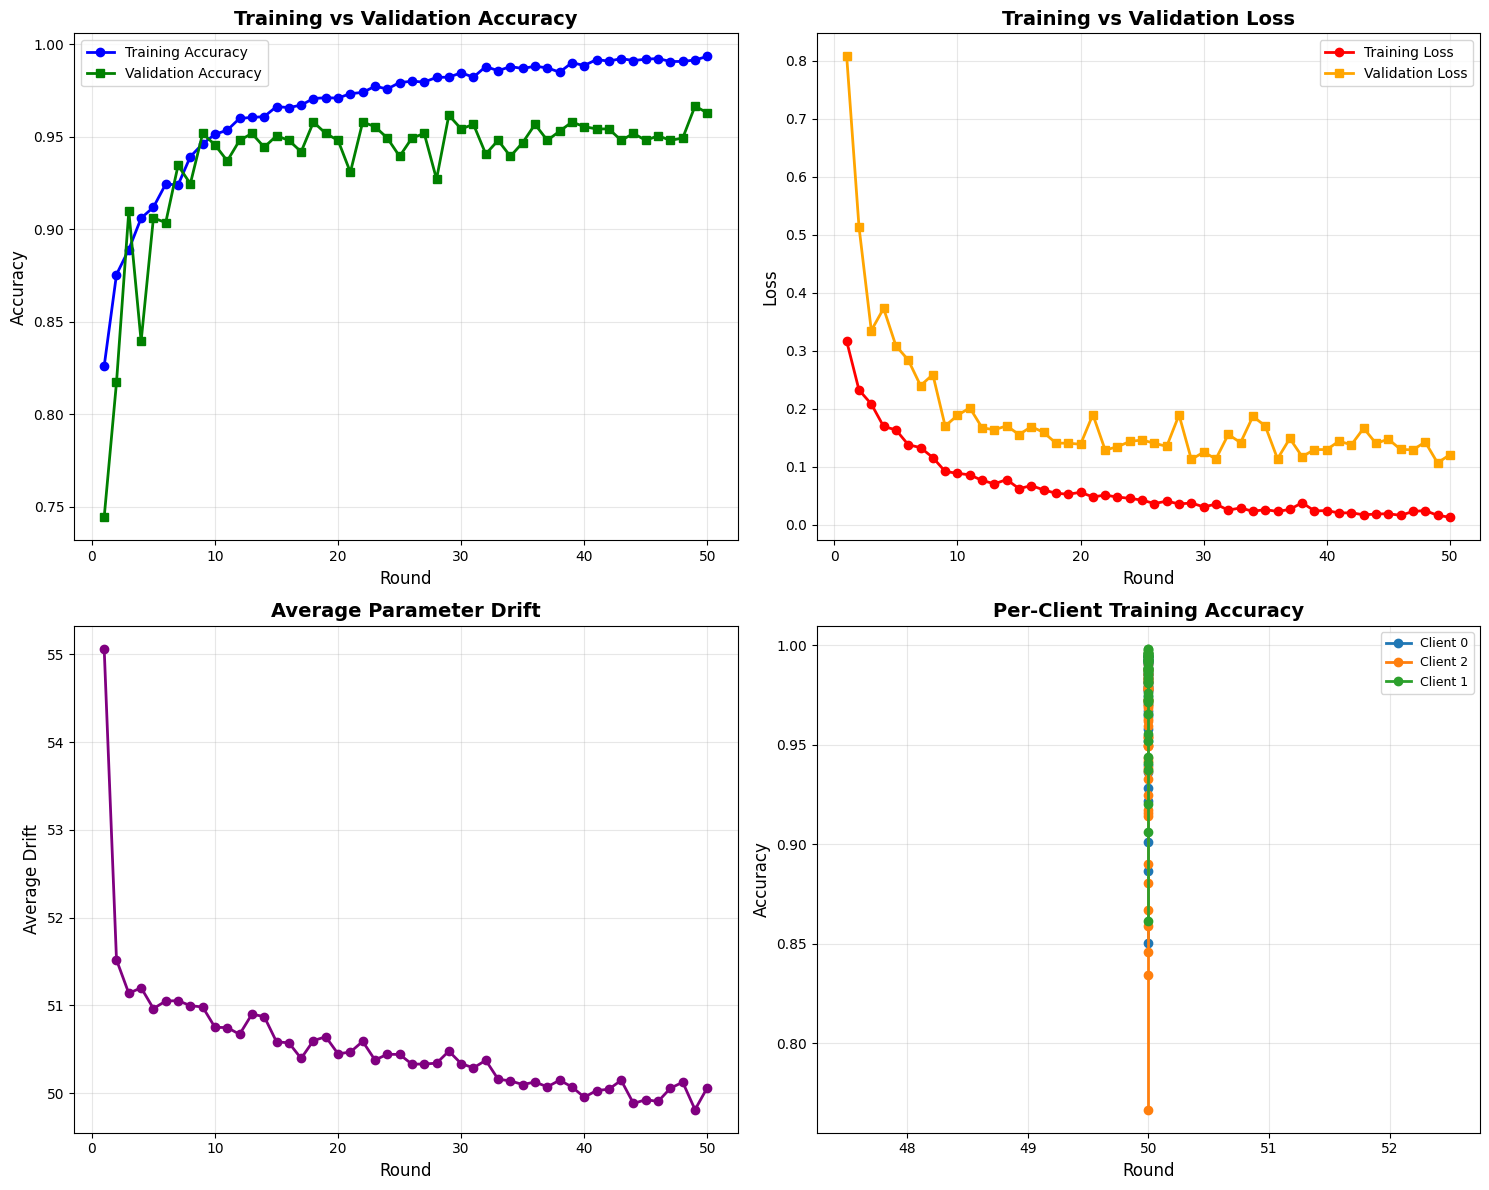

✓ Saved: fedprox_complete_analysis.png

FINAL MODEL EVALUATION
EfficientNet output channels: 1280
MobileNet output channels: 1280
EfficientNet spatial size: torch.Size([7, 7])
MobileNet spatial size: torch.Size([7, 7])
Total concatenated channels: 2560

Final Validation Accuracy: 0.9630

Classification Report:
                          precision    recall  f1-score   support

            Dyskeratotic       0.94      0.97      0.96       136
            Koilocytotic       0.90      0.93      0.92       159
             Metaplastic       0.97      0.92      0.95       166
               Parabasal       1.00      0.99      0.99       173
Superficial-Intermediate       0.99      1.00      0.99       176

                accuracy                           0.96       810
               macro avg       0.96      0.96      0.96       810
            weighted avg       0.96      0.96      0.96       810



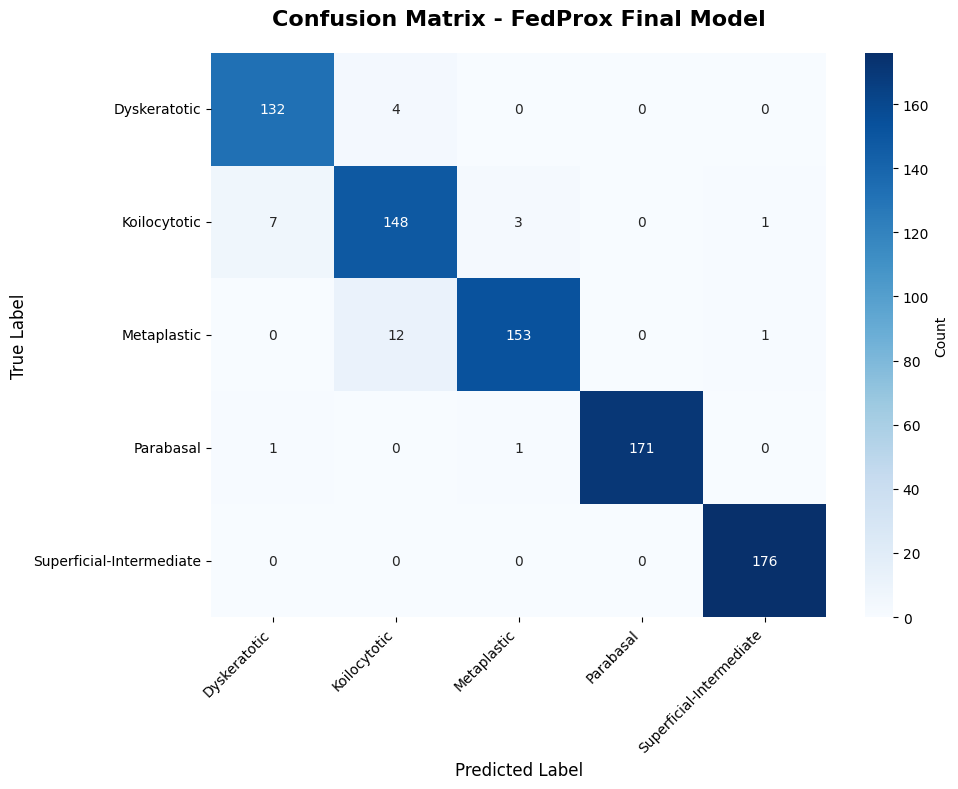

✓ Saved: fedprox_confusion_matrix.png

ALL RESULTS GENERATED SUCCESSFULLY
Final Model Accuracy: 0.9630


In [72]:
def evaluate_final_model(strategy):
    """Evaluate final model and generate confusion matrix"""
    print("\n" + "="*60)
    print("FINAL MODEL EVALUATION")
    print("="*60)
    
    final_params = strategy.round_results[-1]['parameters']
    final_params_np = parameters_to_ndarrays(final_params)
    
    model = HybridDenseViT(num_classes=5, dropout=0.5)
    set_parameters(model, final_params_np)
    model.to(DEVICE)
    model.eval()
    
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for images, labels in global_valloader:
            images = images.to(DEVICE)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.numpy())
    
    all_preds = np.array(all_preds)
    all_labels = np.array(all_labels)
    
    accuracy = accuracy_score(all_labels, all_preds)
    print(f"\nFinal Validation Accuracy: {accuracy:.4f}")
    
    class_names = ['Dyskeratotic', 'Koilocytotic', 'Metaplastic', 
                   'Parabasal', 'Superficial-Intermediate']
    
    print("\nClassification Report:")
    print(classification_report(all_labels, all_preds, target_names=class_names))
    
    cm = confusion_matrix(all_labels, all_preds)
    
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=class_names, yticklabels=class_names,
                cbar_kws={'label': 'Count'})
    plt.title('Confusion Matrix - FedProx Final Model', fontsize=16, fontweight='bold', pad=20)
    plt.ylabel('True Label', fontsize=12)
    plt.xlabel('Predicted Label', fontsize=12)
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.savefig('fedprox_confusion_matrix.png', dpi=300, bbox_inches='tight')
    plt.show()
    print("✓ Saved: fedprox_confusion_matrix.png")
    
    return accuracy, all_preds, all_labels

# Generate all visualizations
print("\n" + "="*60)
print("GENERATING VISUALIZATIONS AND FINAL EVALUATION")
print("="*60)

plot_fedprox_results(global_strategy)
final_accuracy, predictions, labels = evaluate_final_model(global_strategy)

print("\n" + "="*60)
print("ALL RESULTS GENERATED SUCCESSFULLY")
print("="*60)
print(f"Final Model Accuracy: {final_accuracy:.4f}")
print("="*60)